C:\Users\Joy\AppData\Local\Temp\ipykernel_17976\3016916211.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("Nan", np.nan, inplace=True)


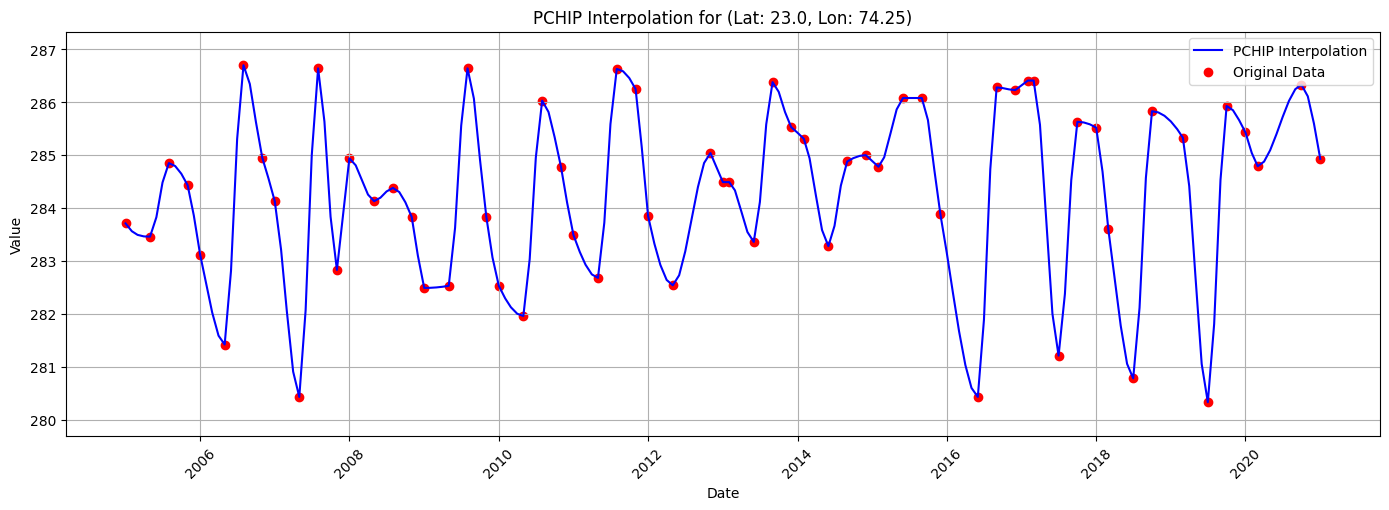

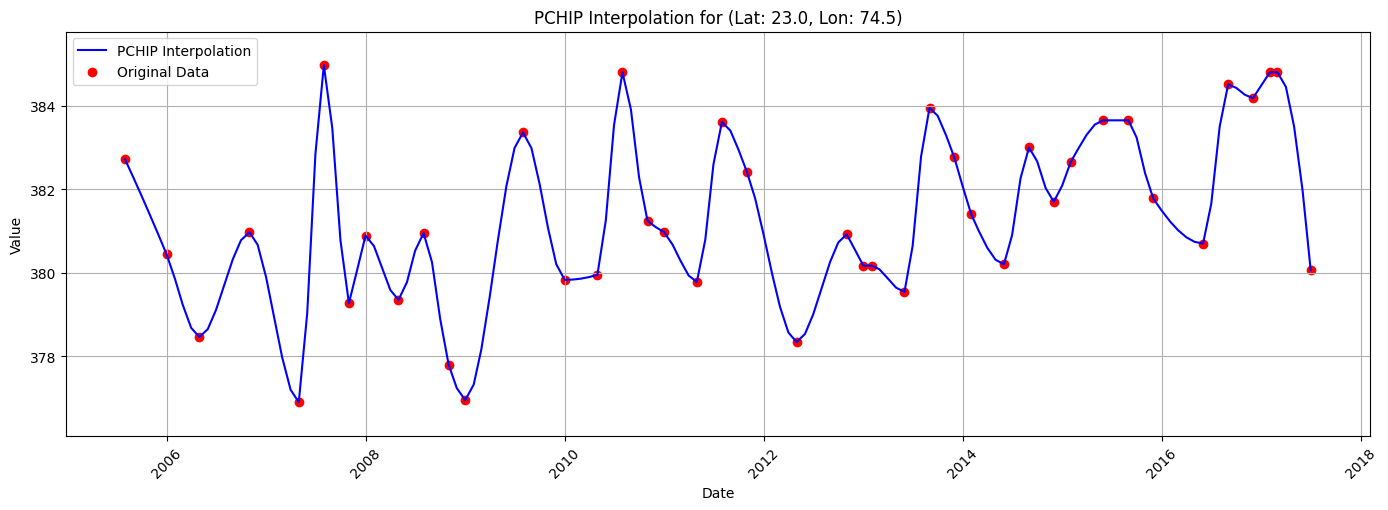

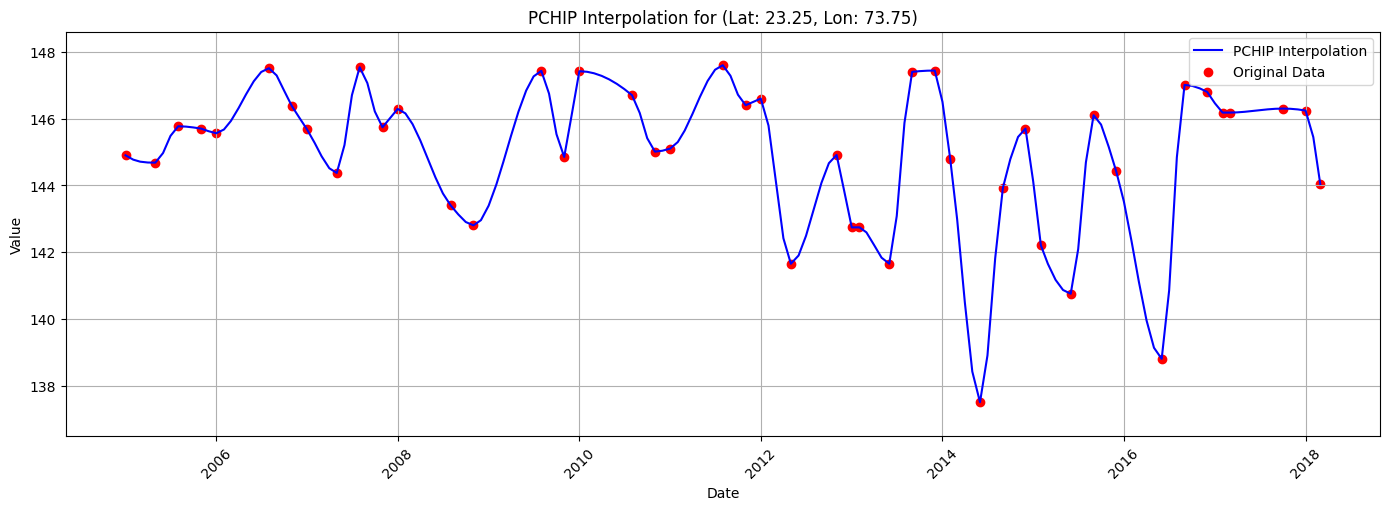

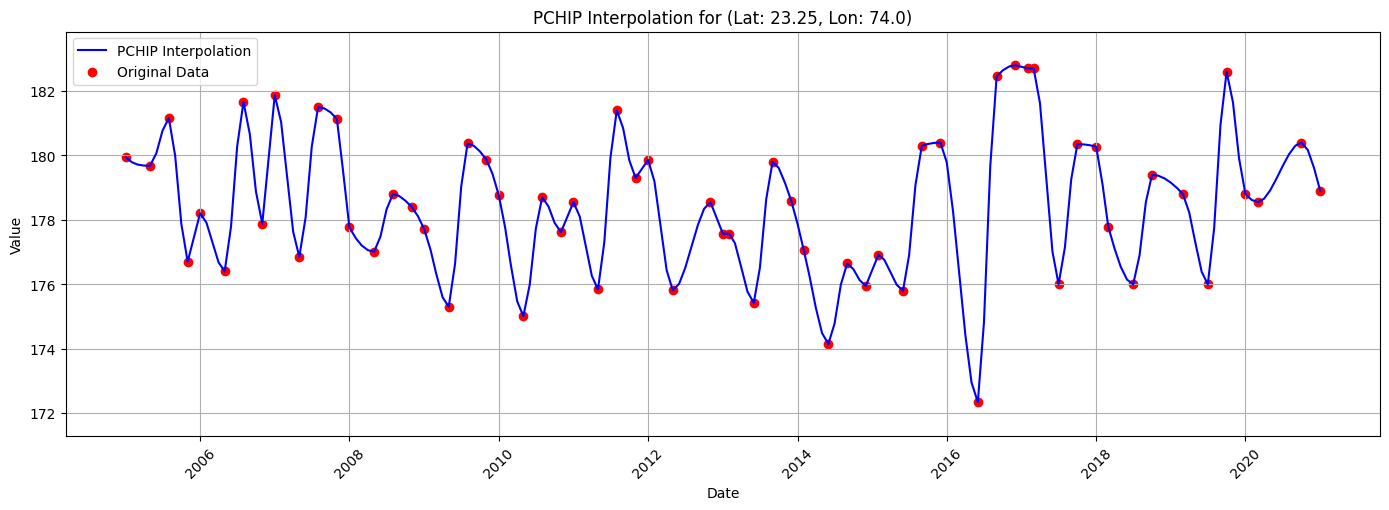

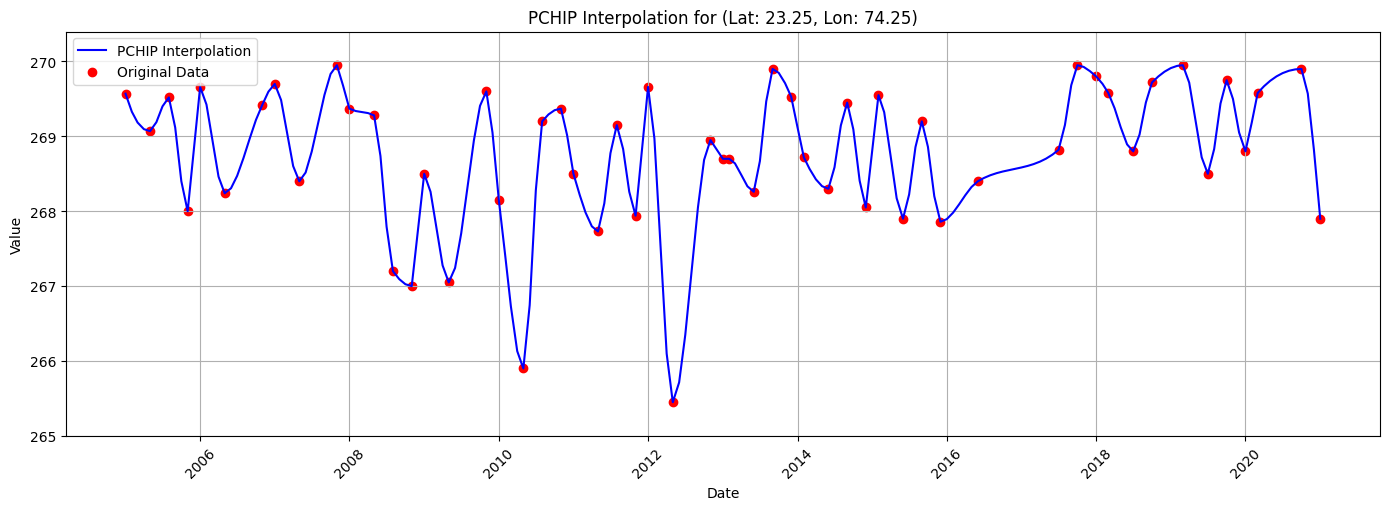

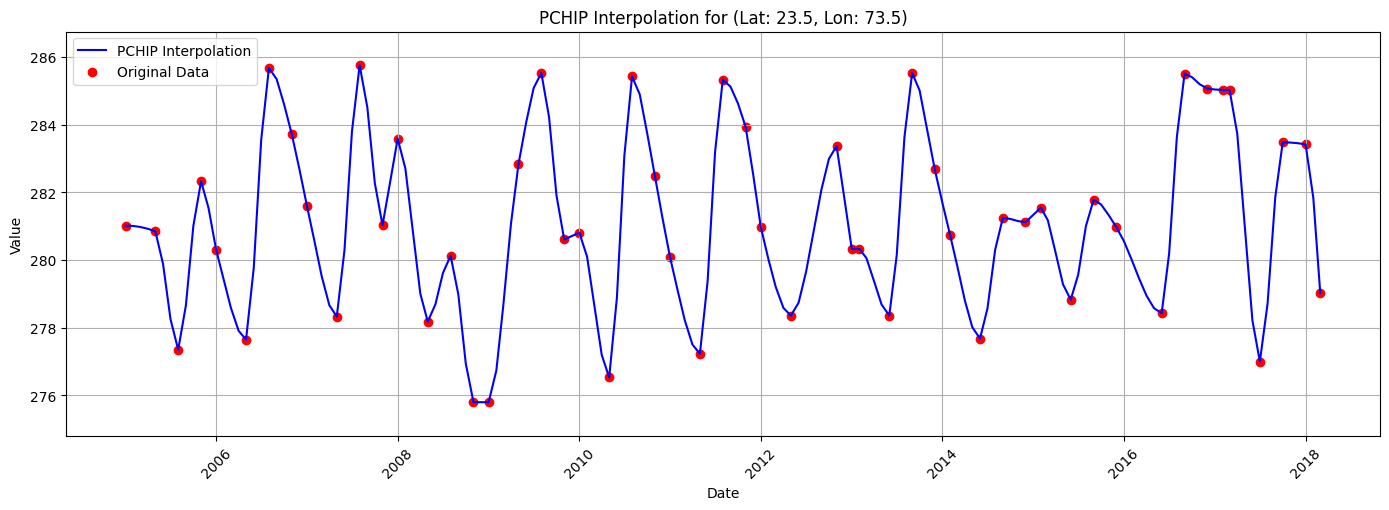

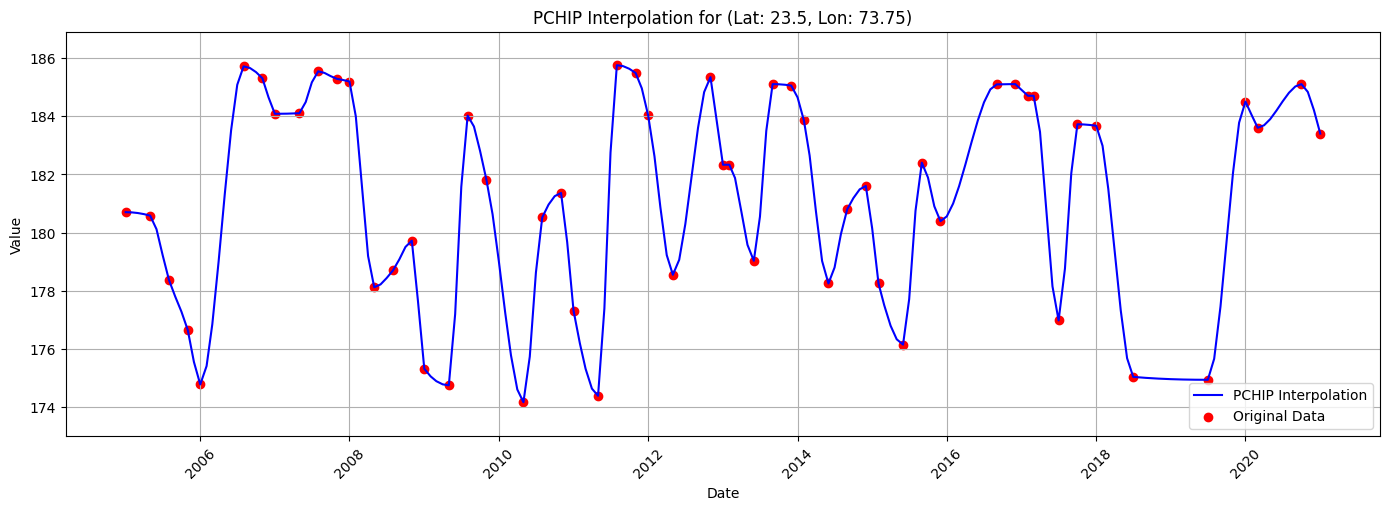

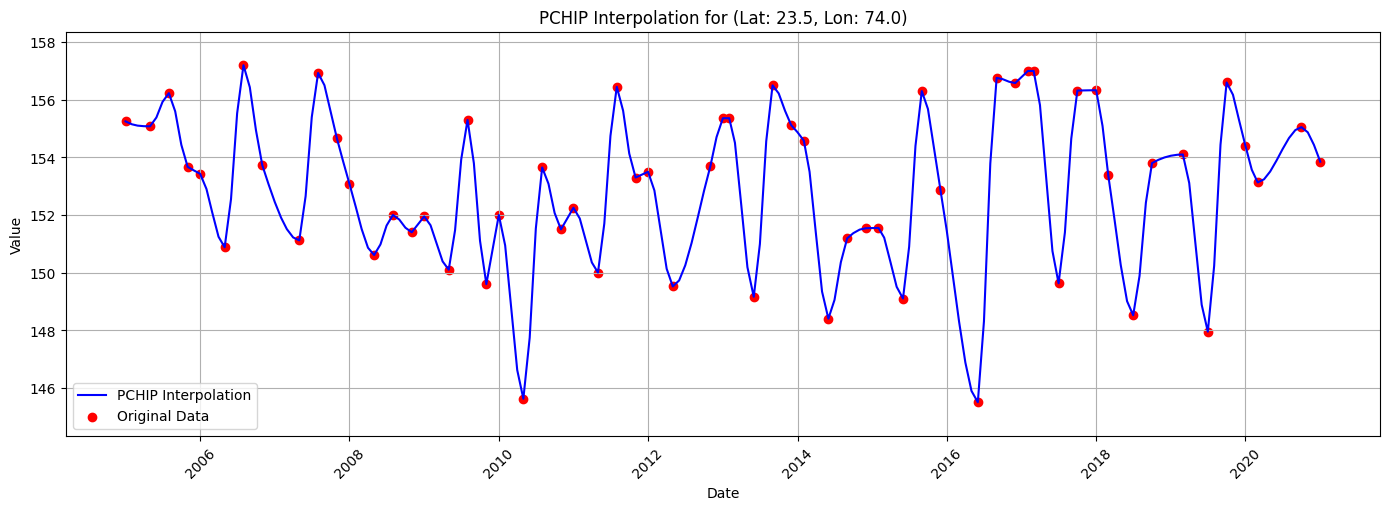

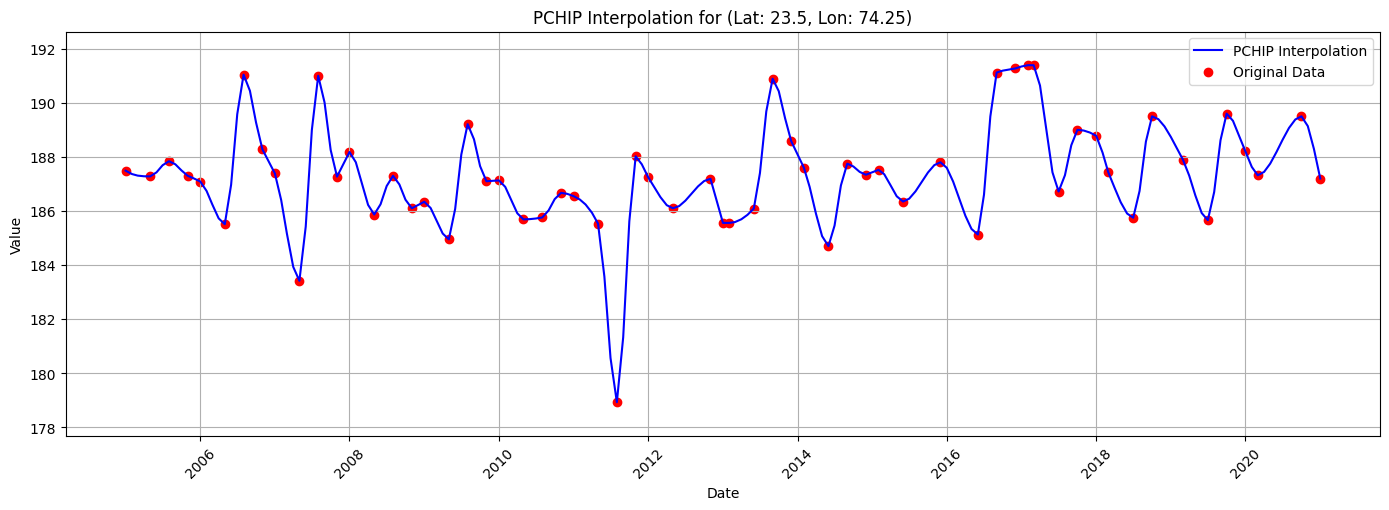

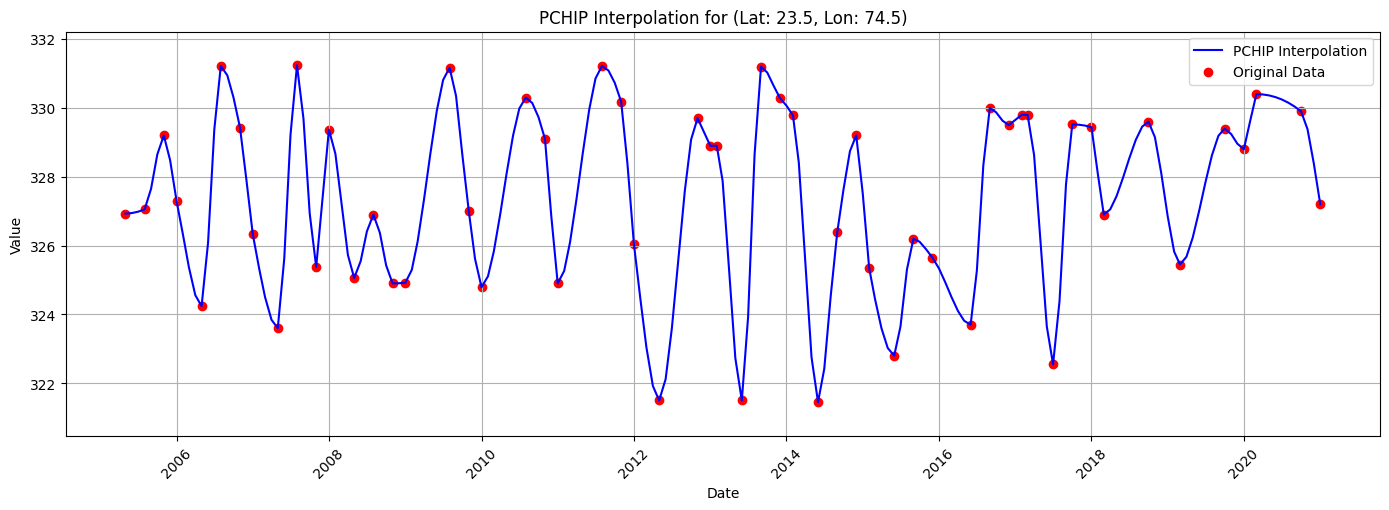

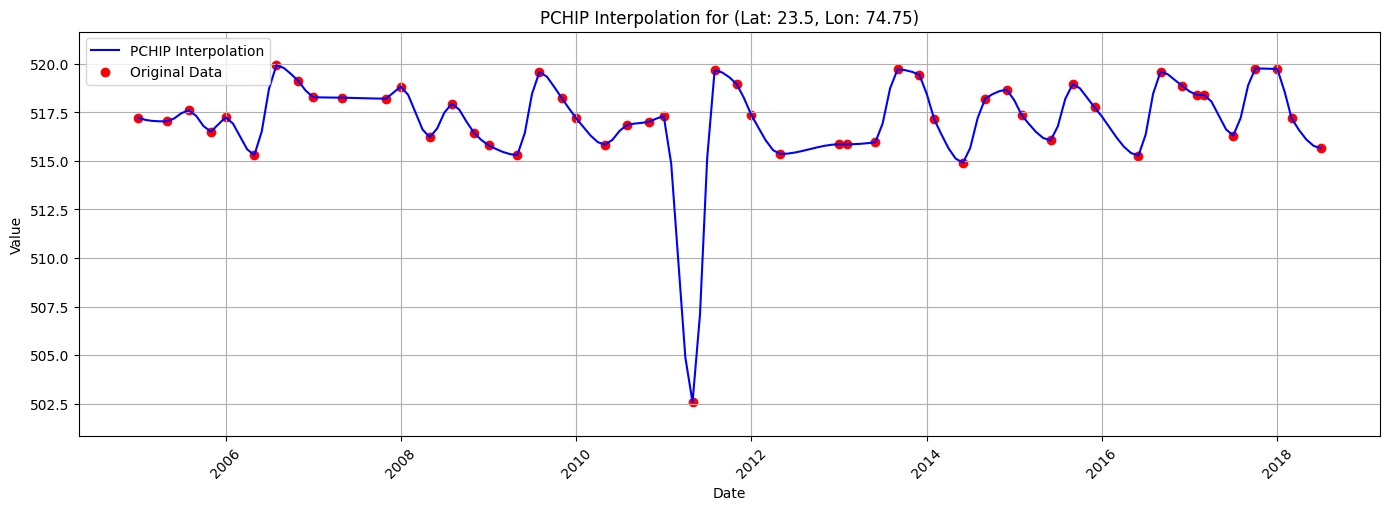

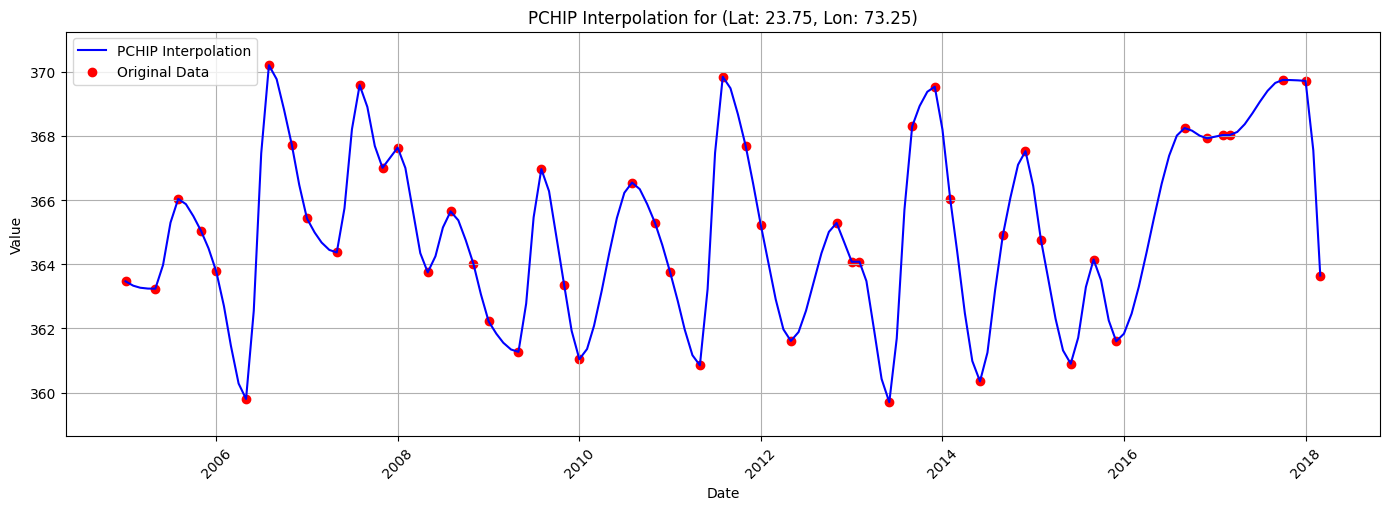

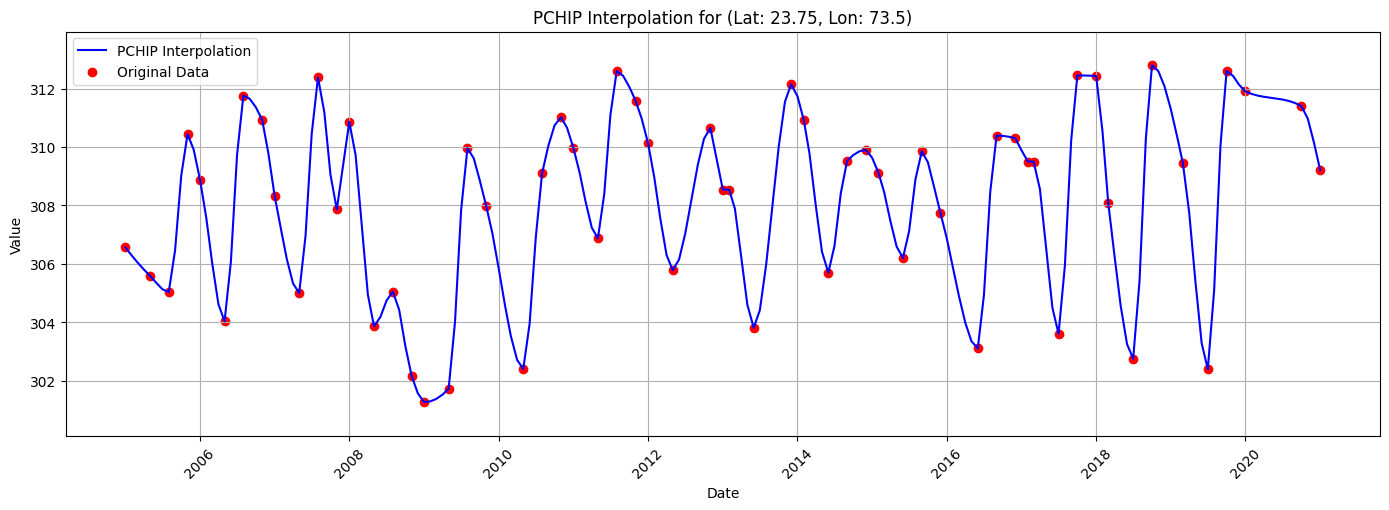

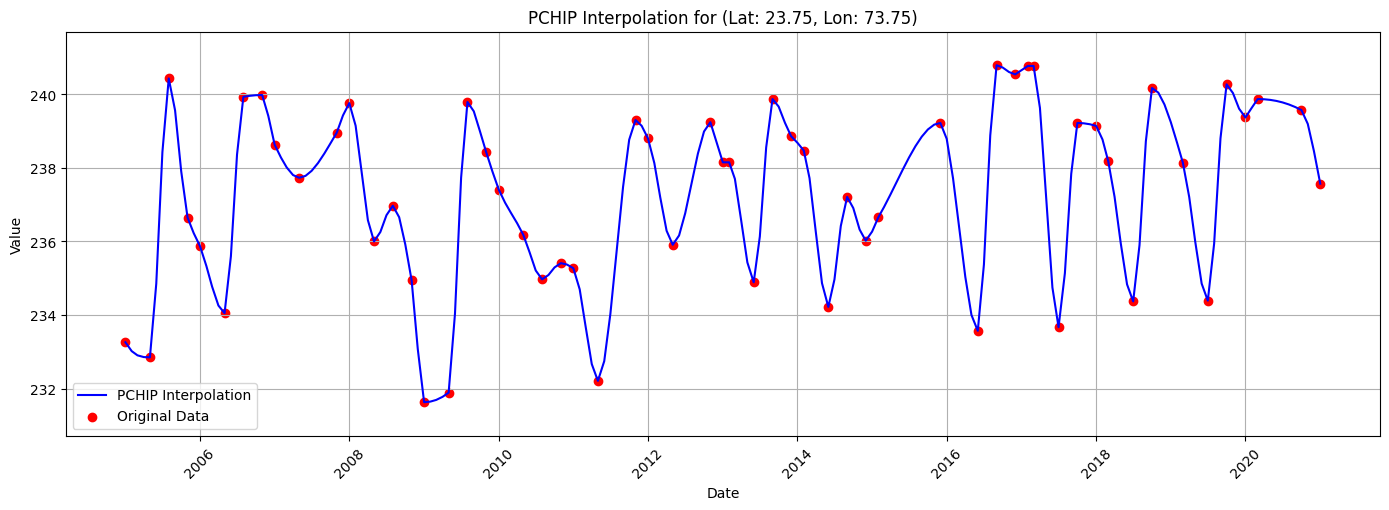

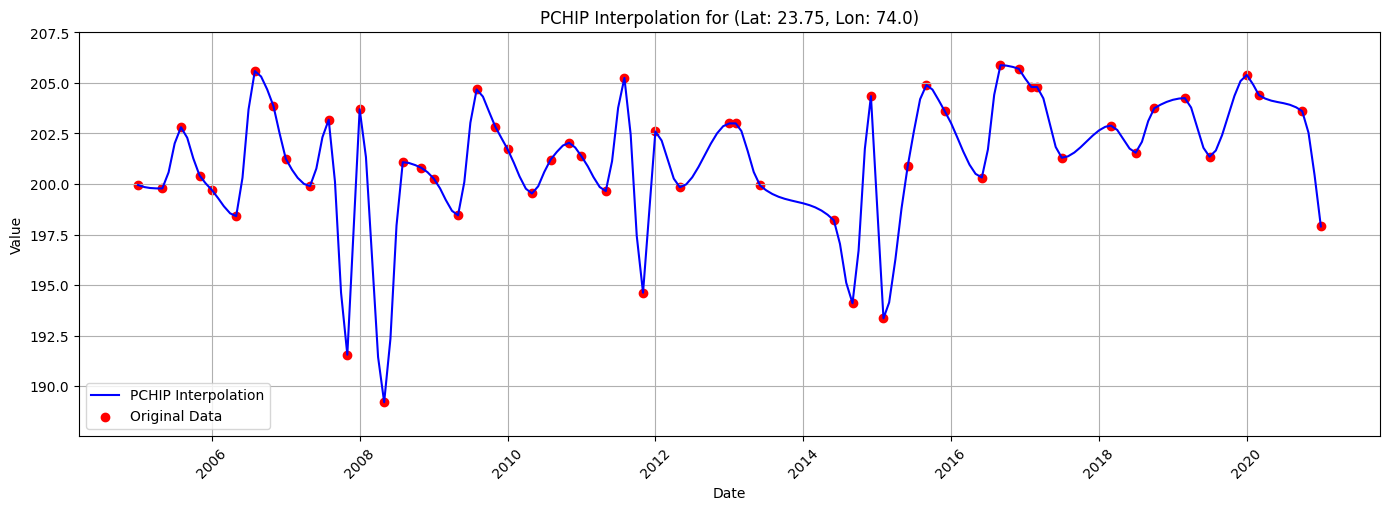

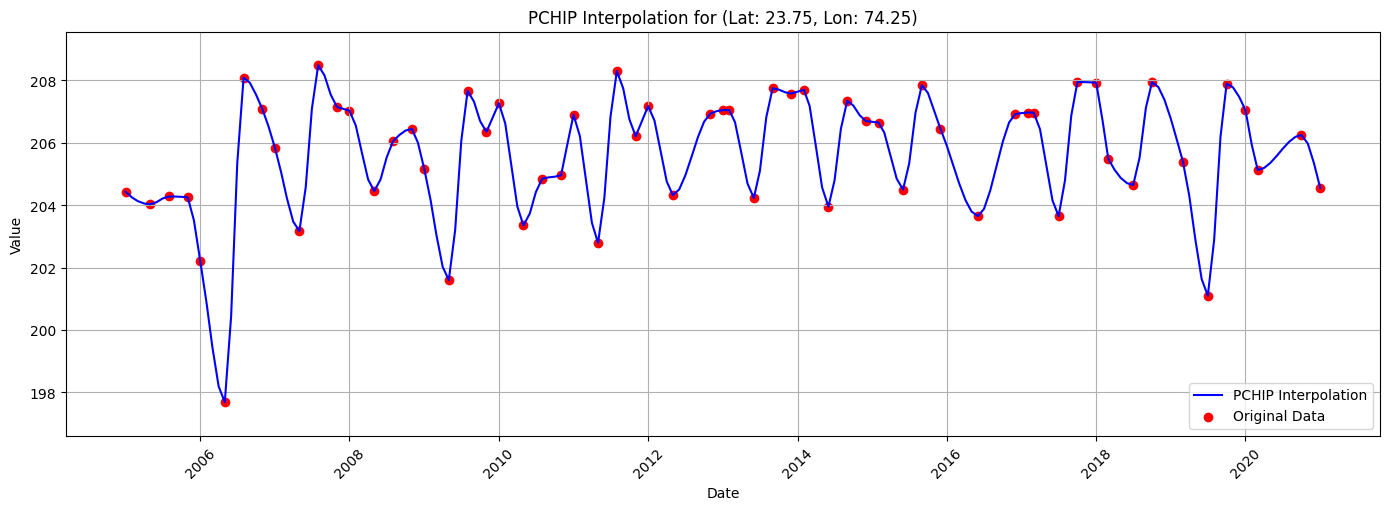

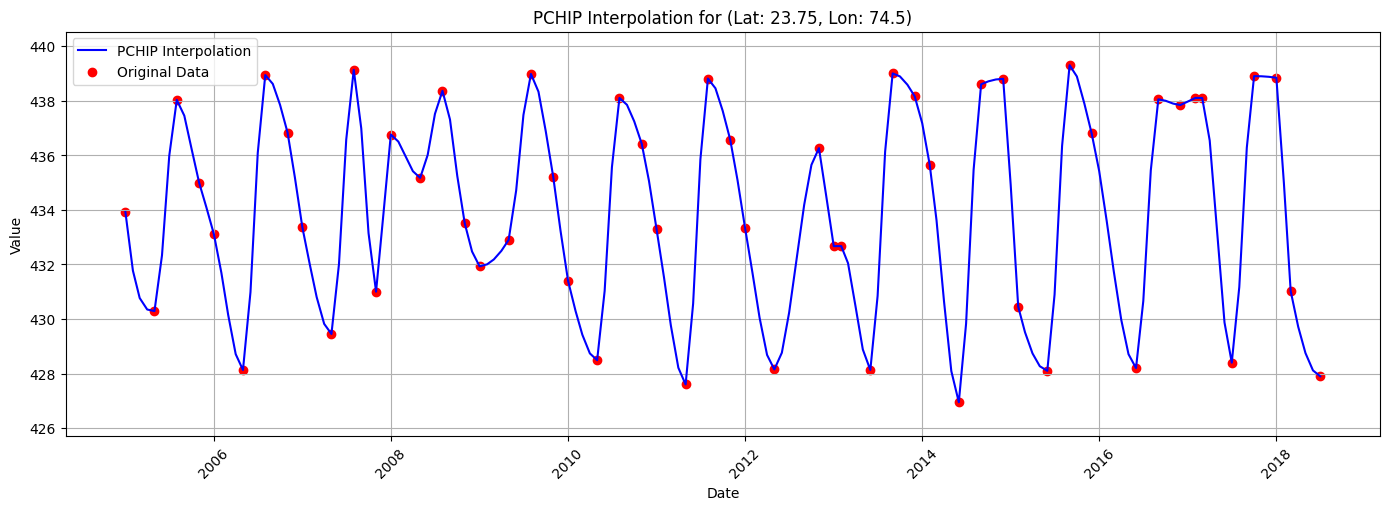

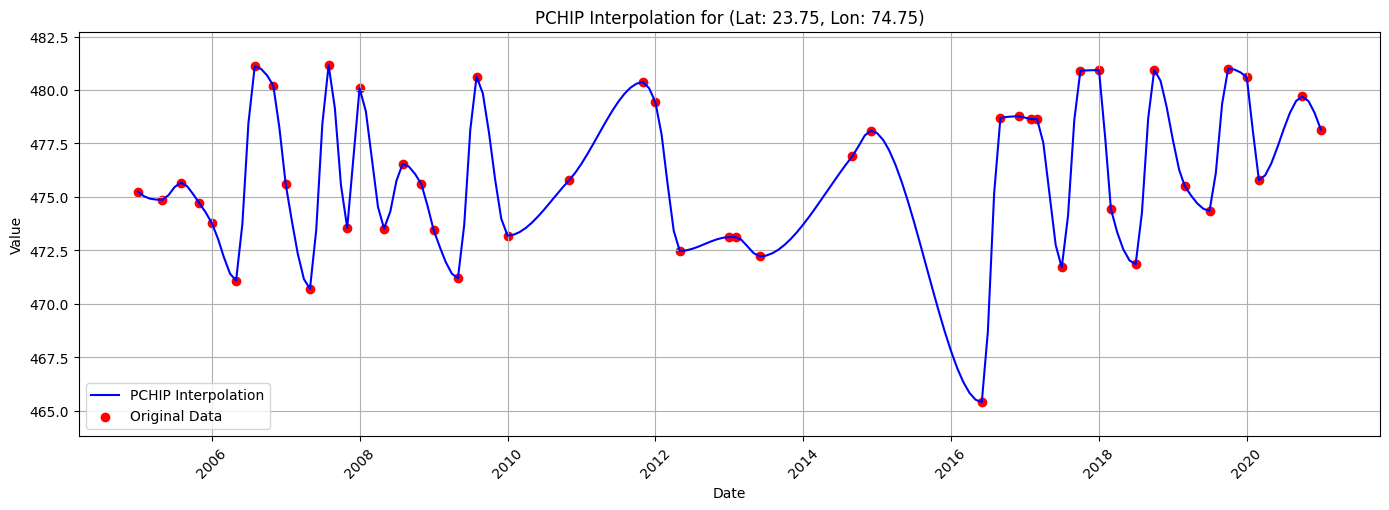

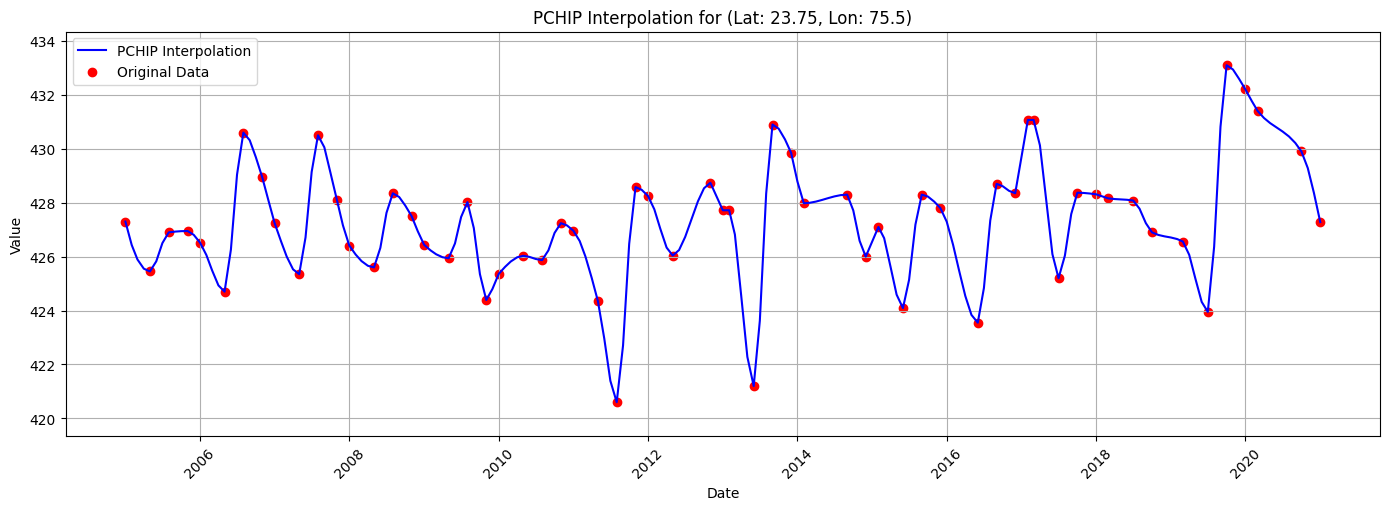

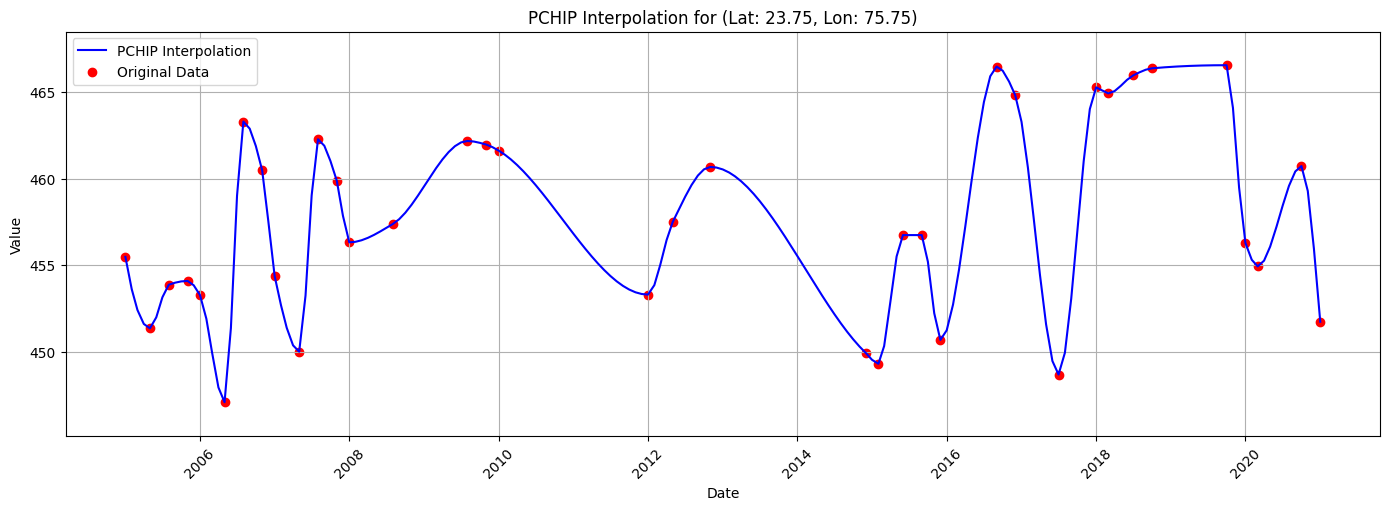

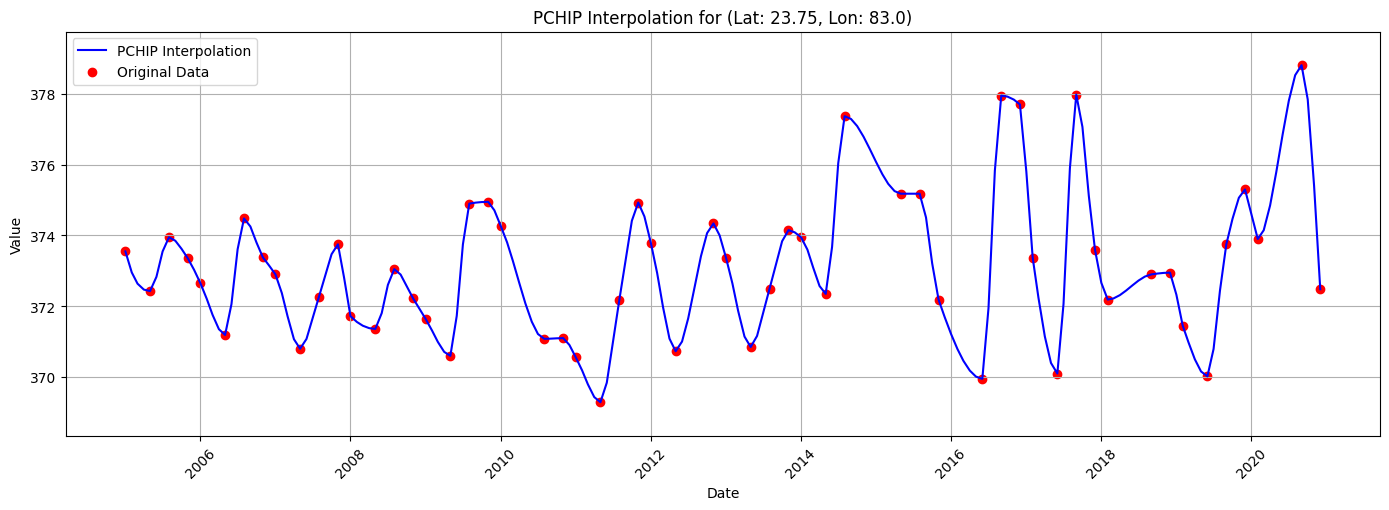

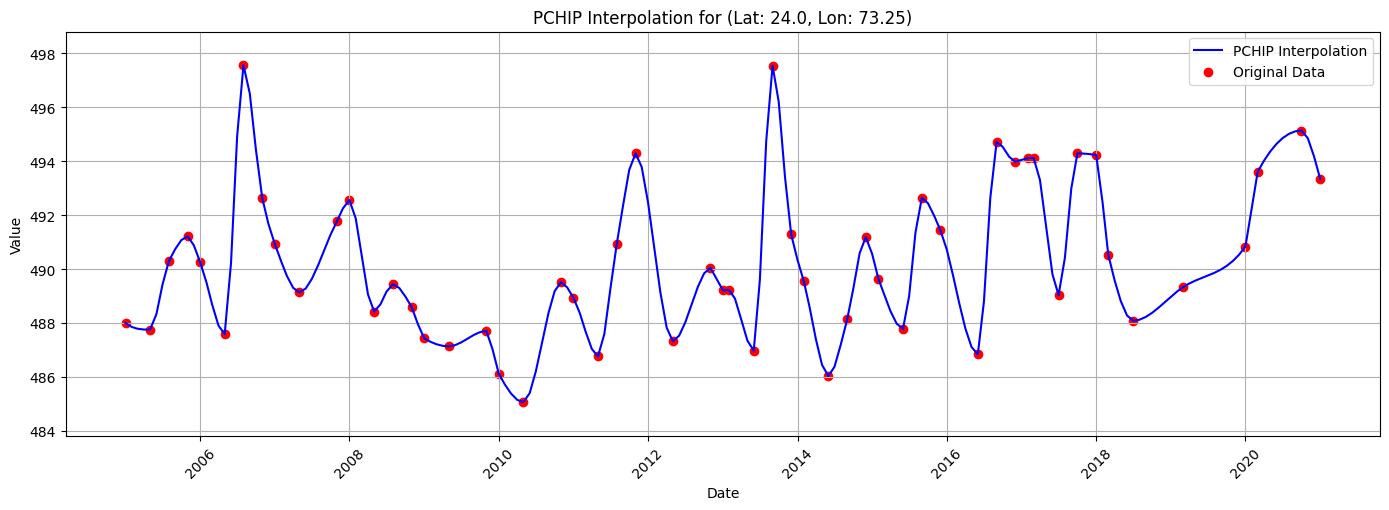

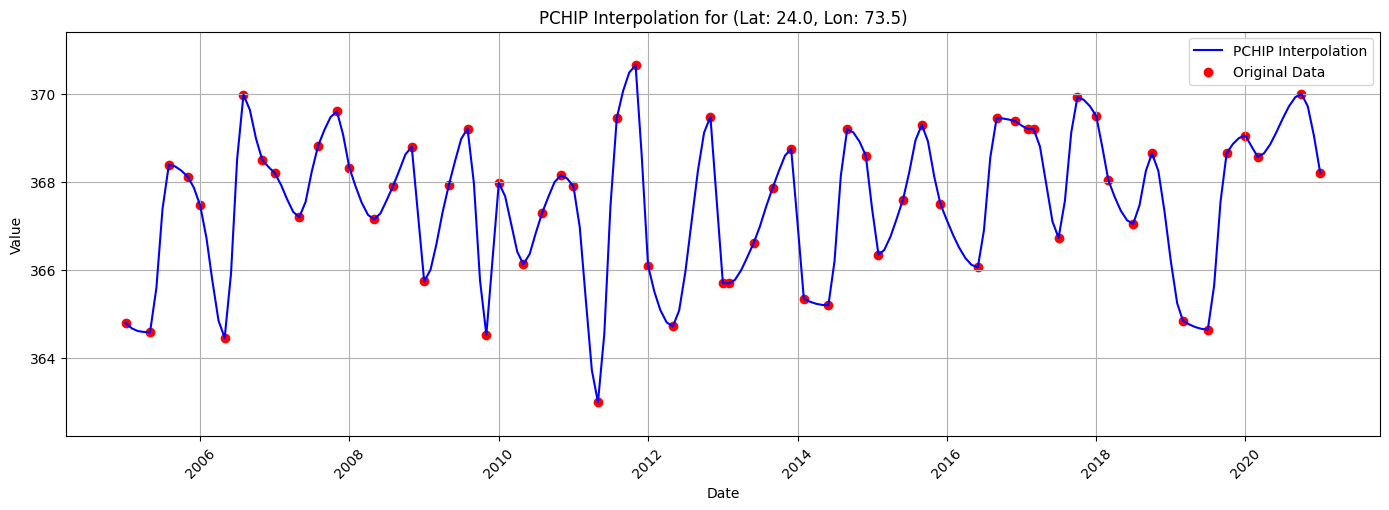

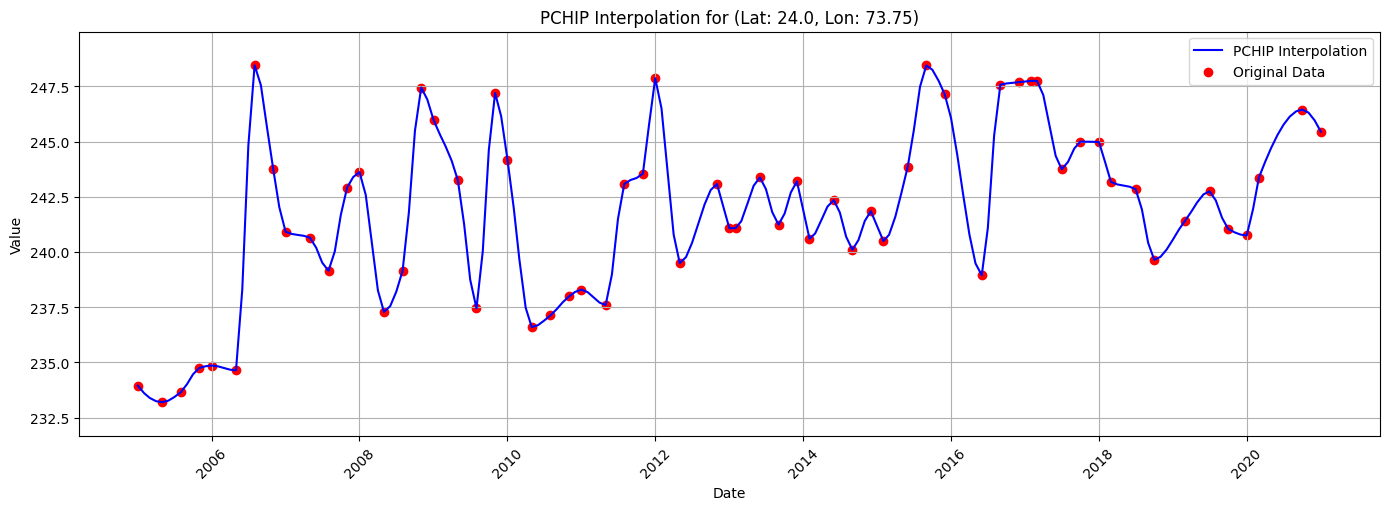

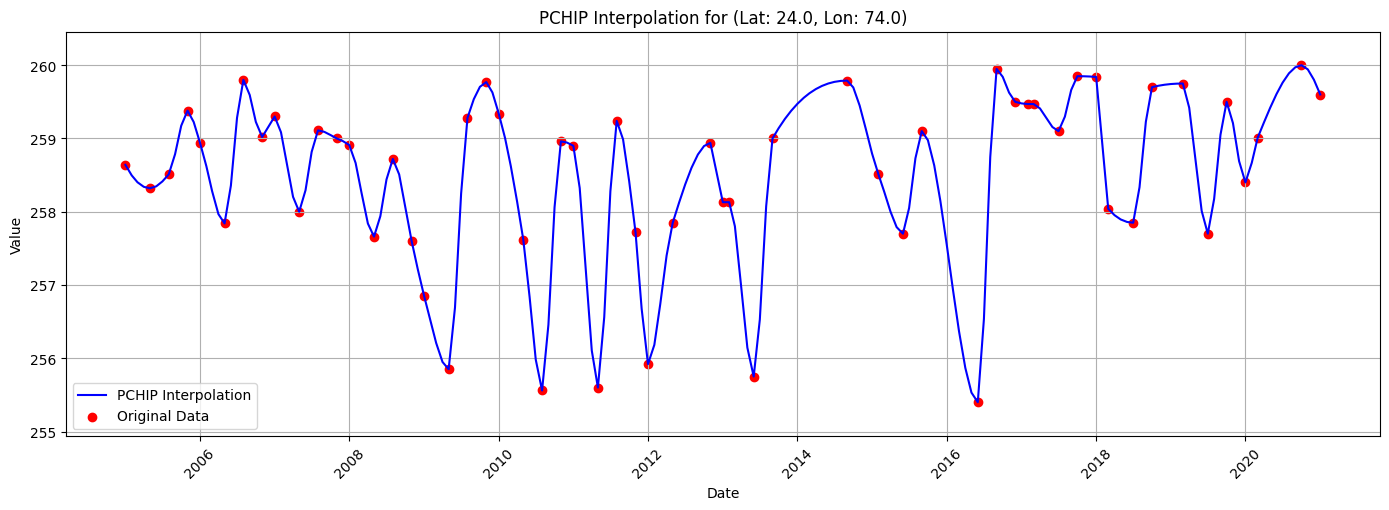

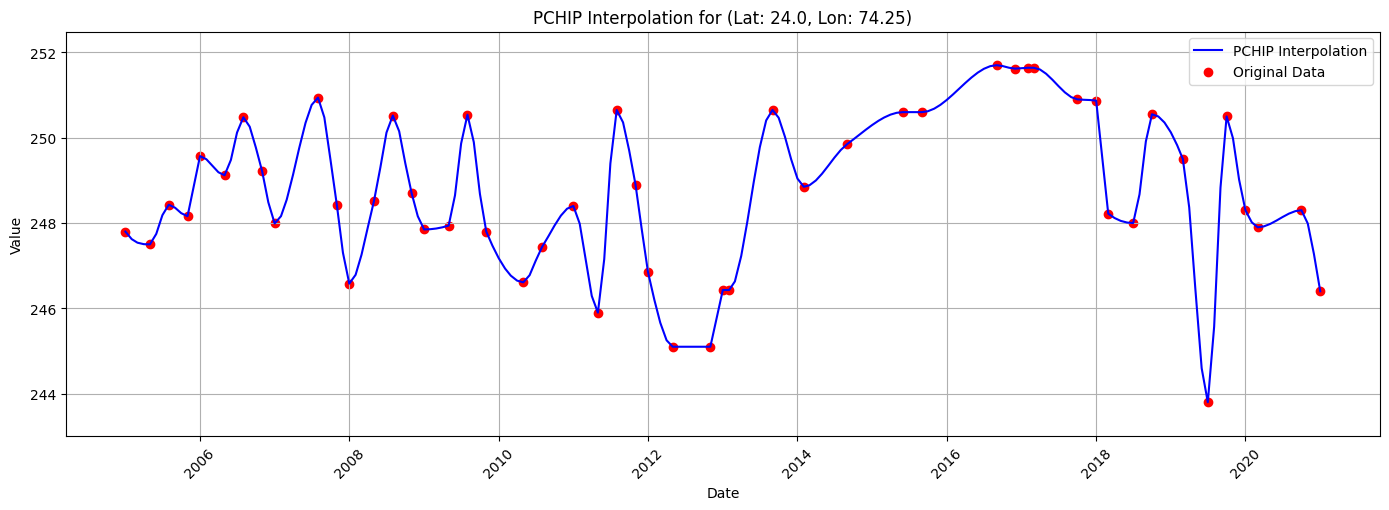

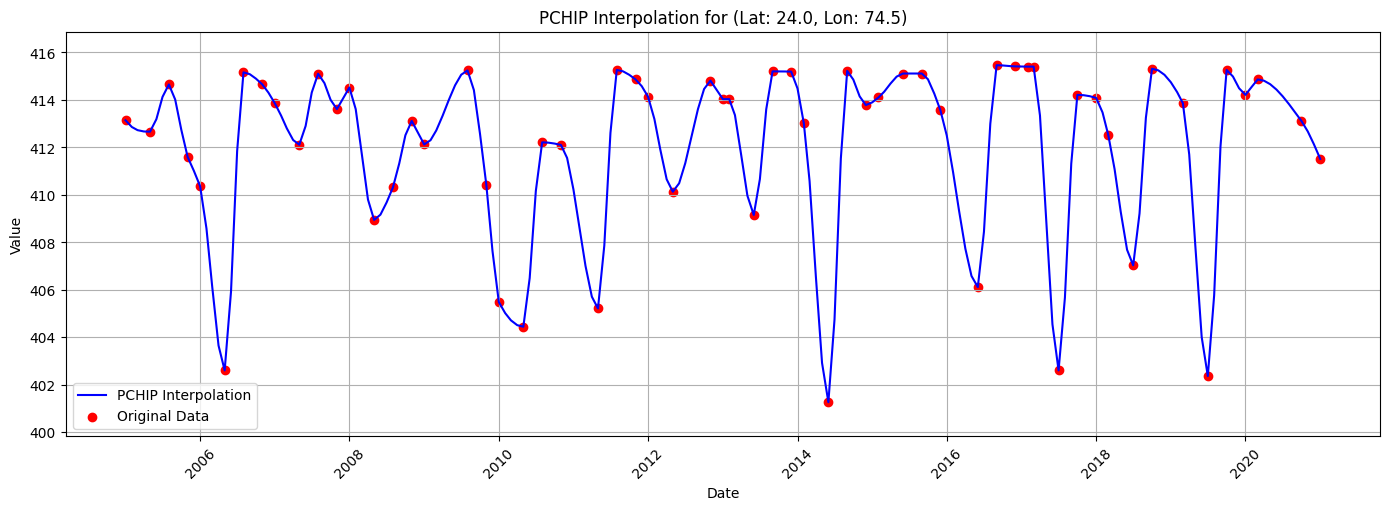

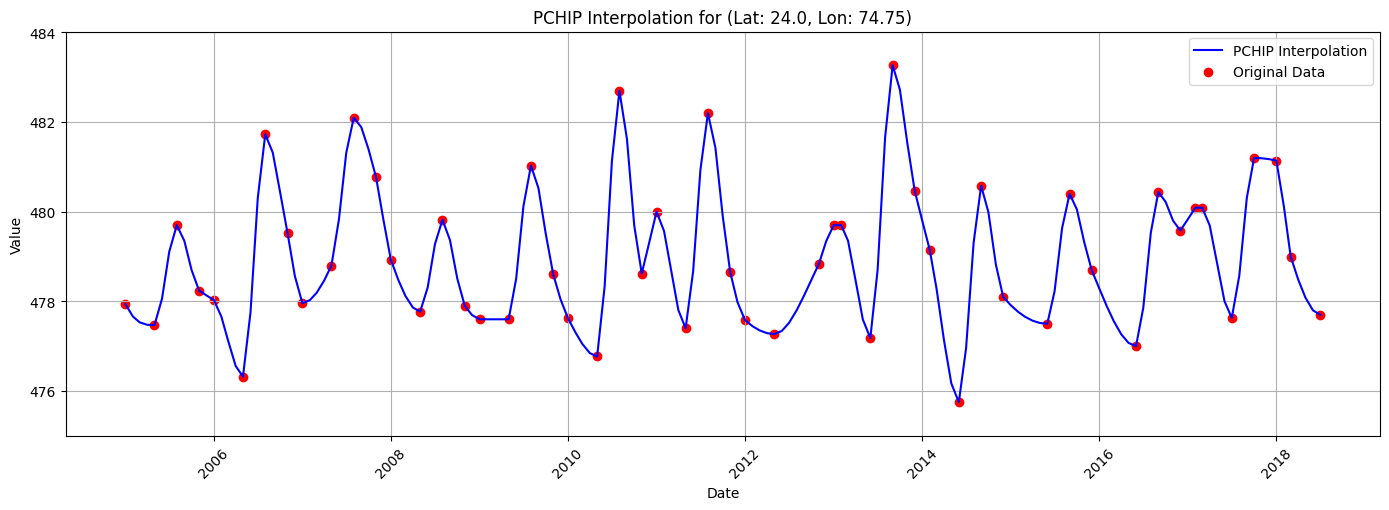

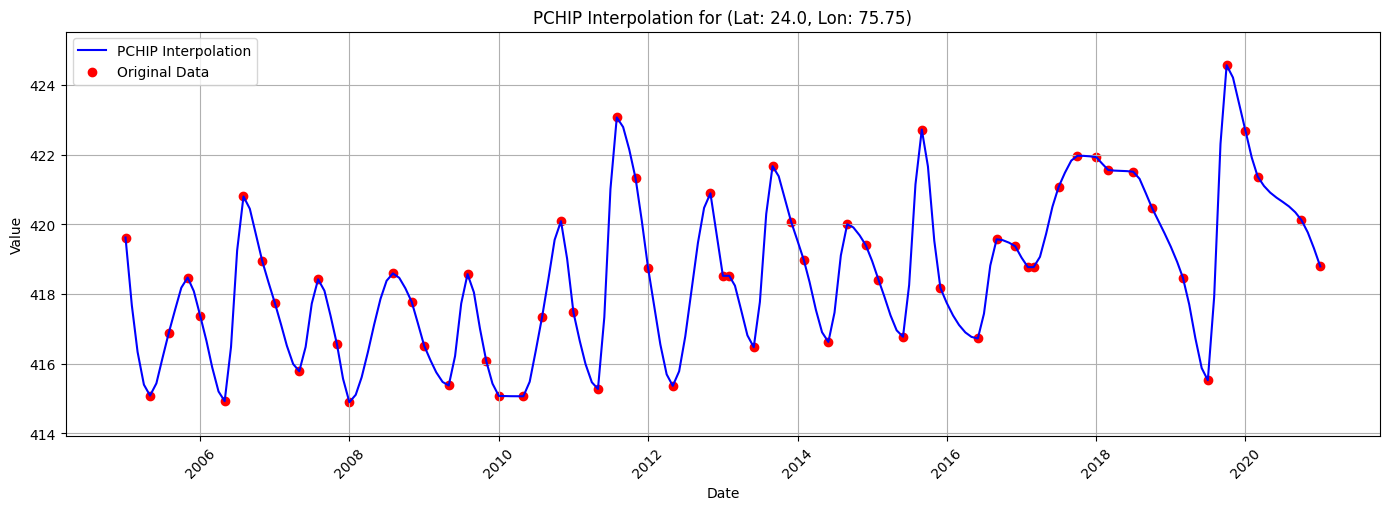

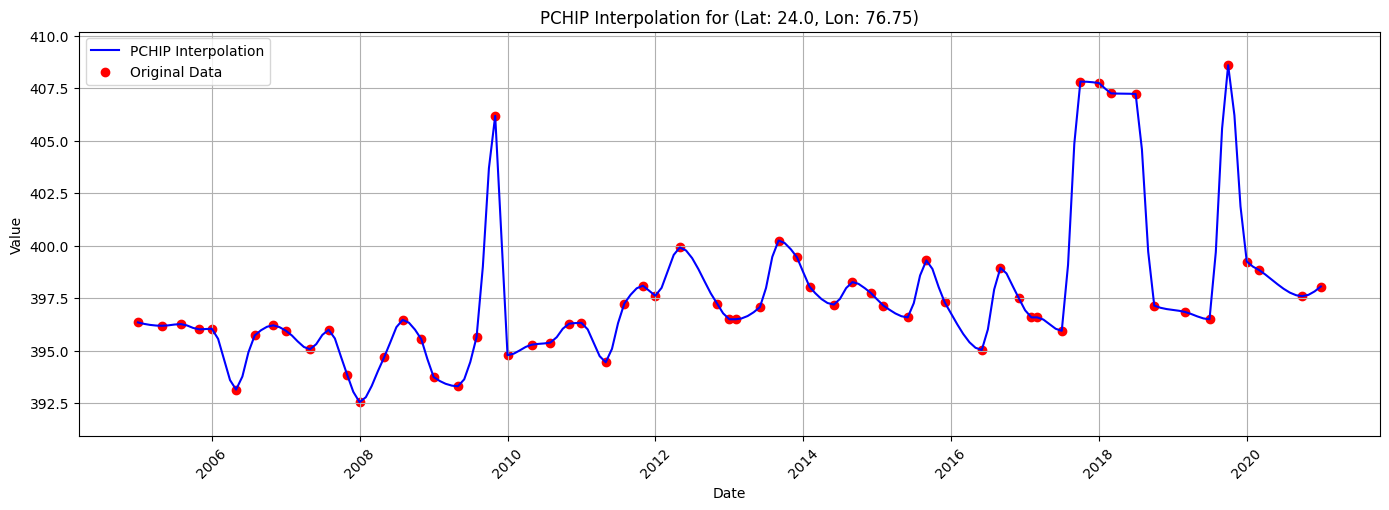

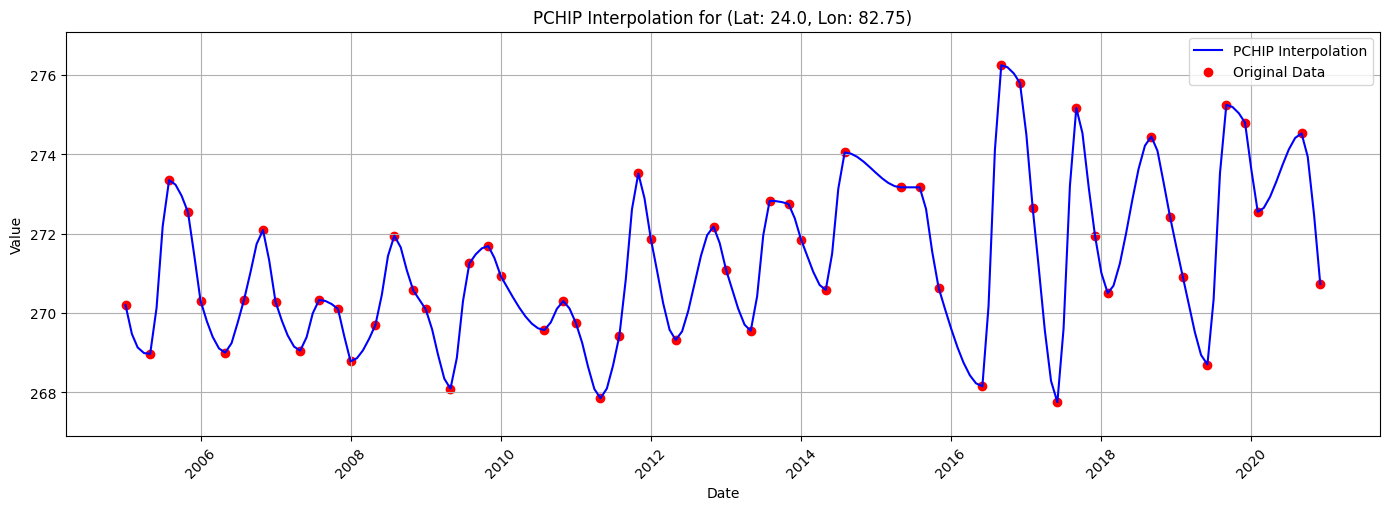

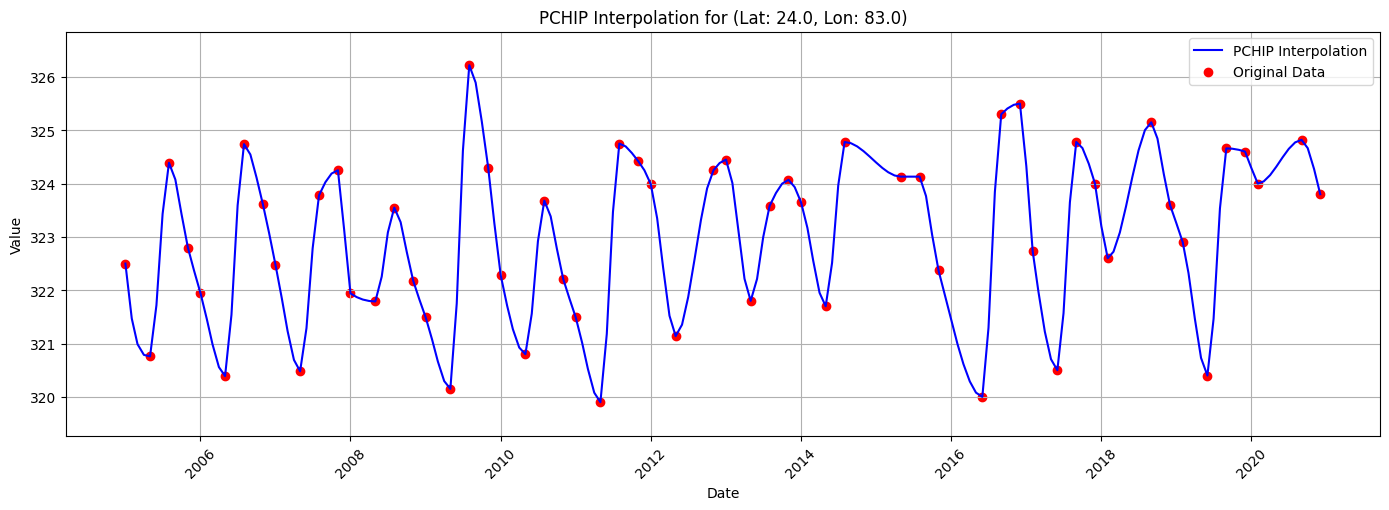

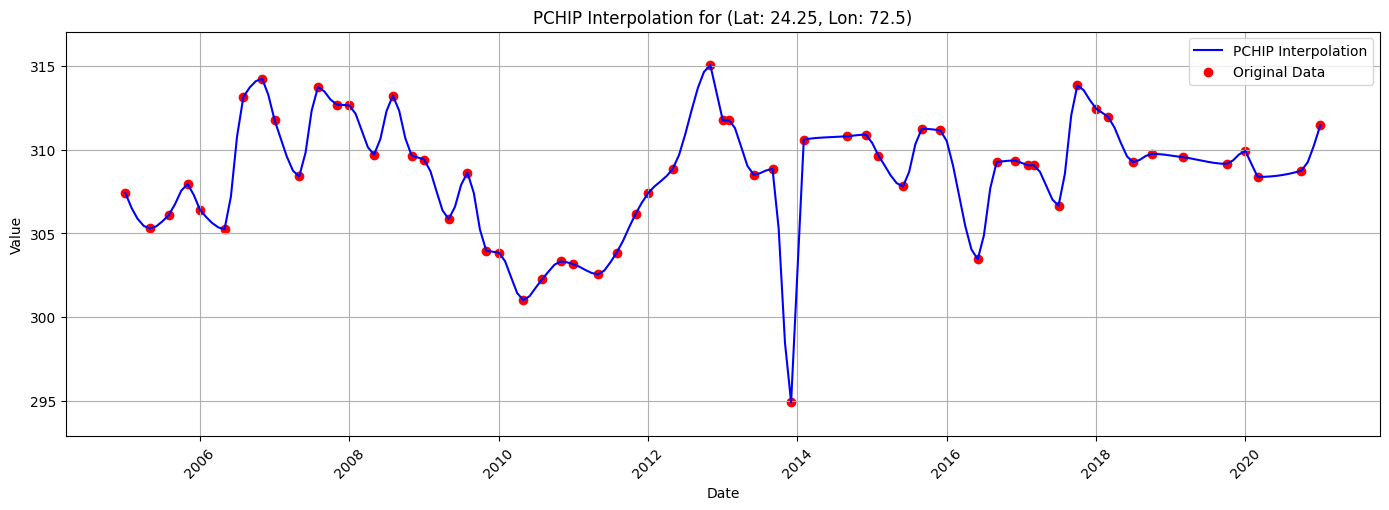

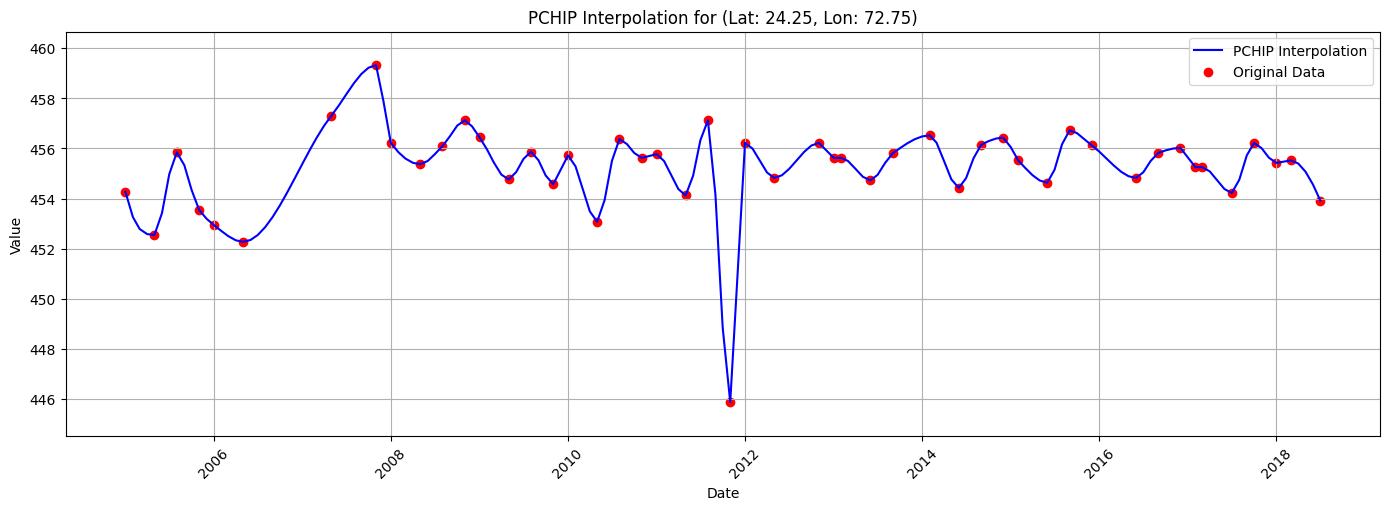

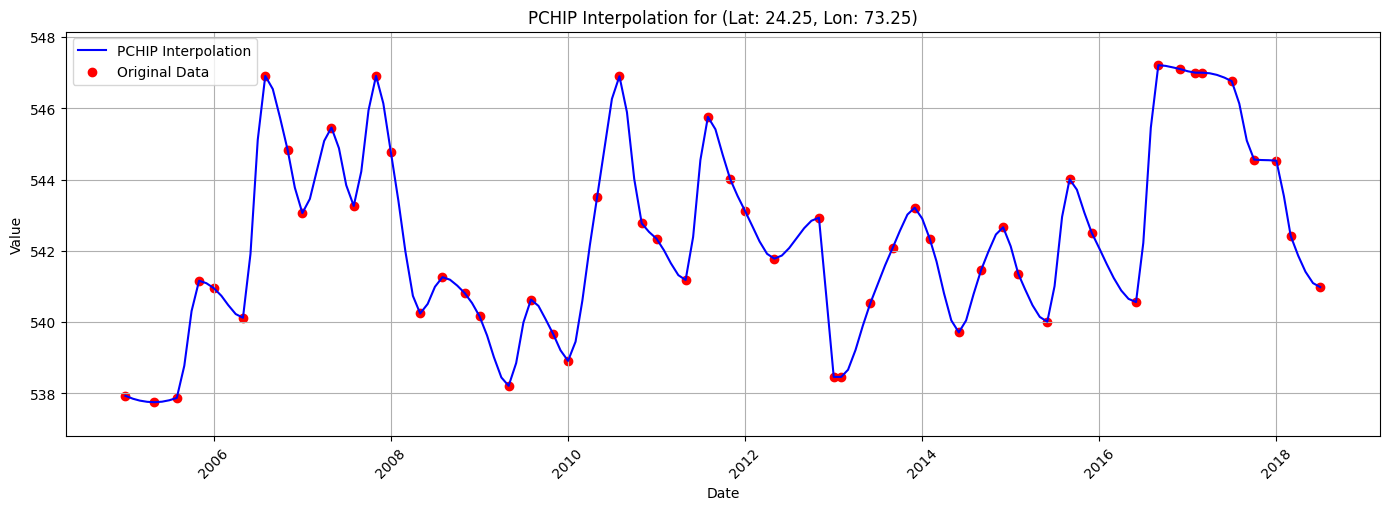

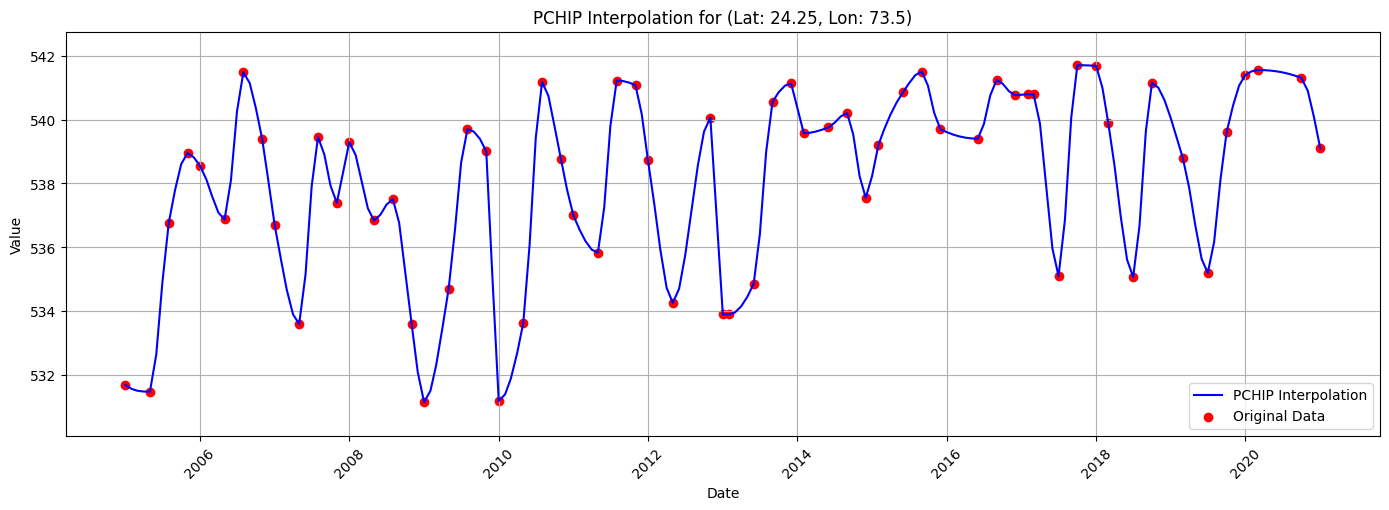

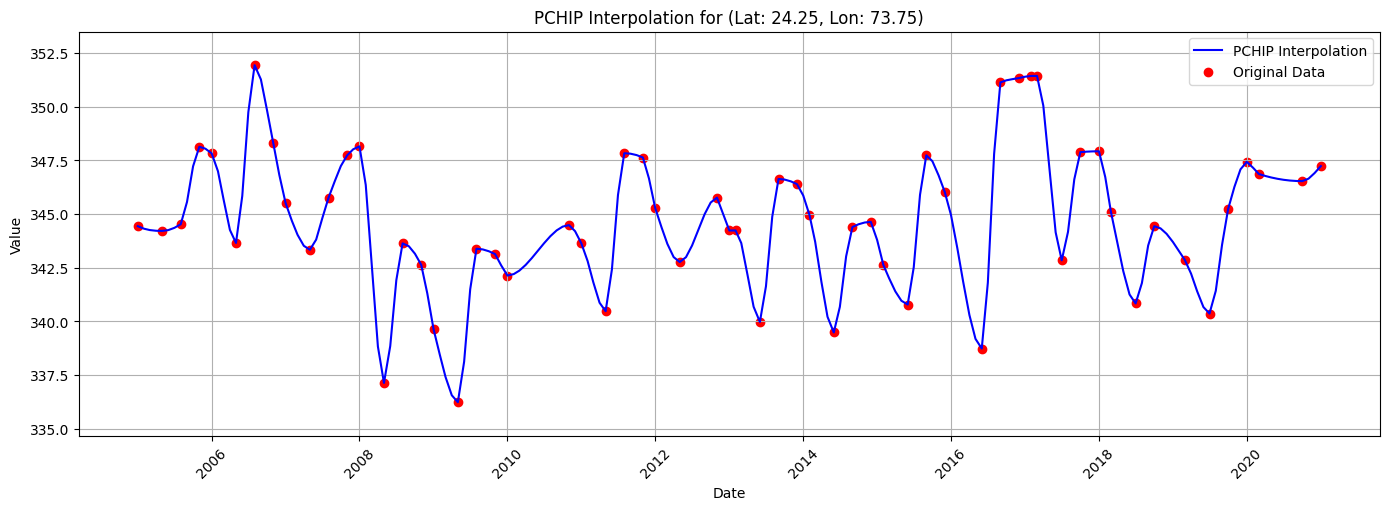

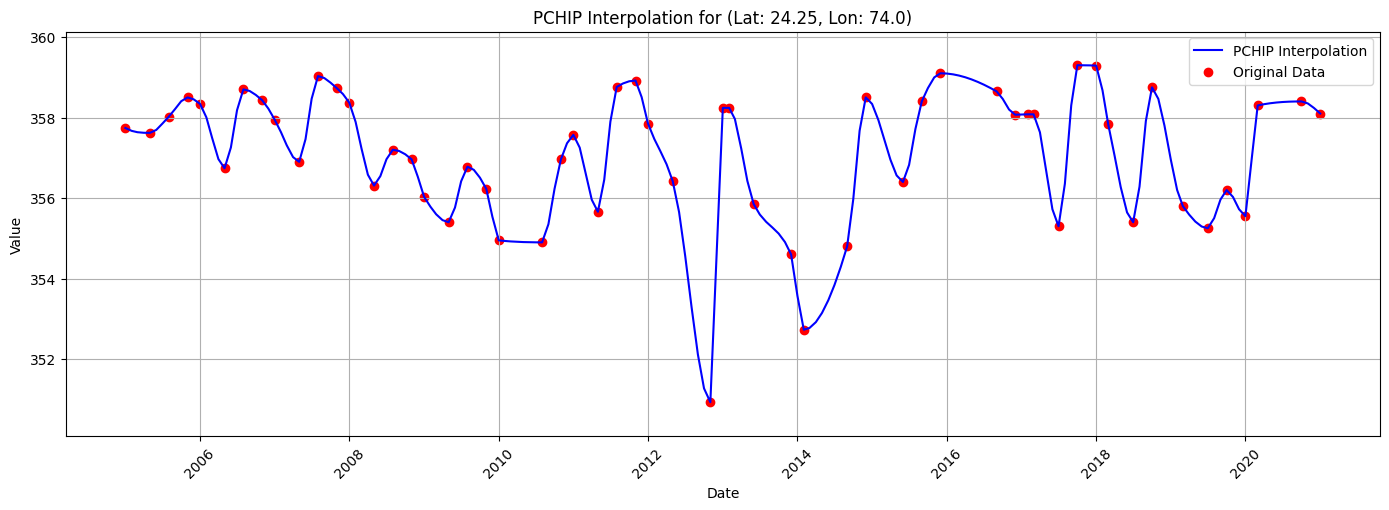

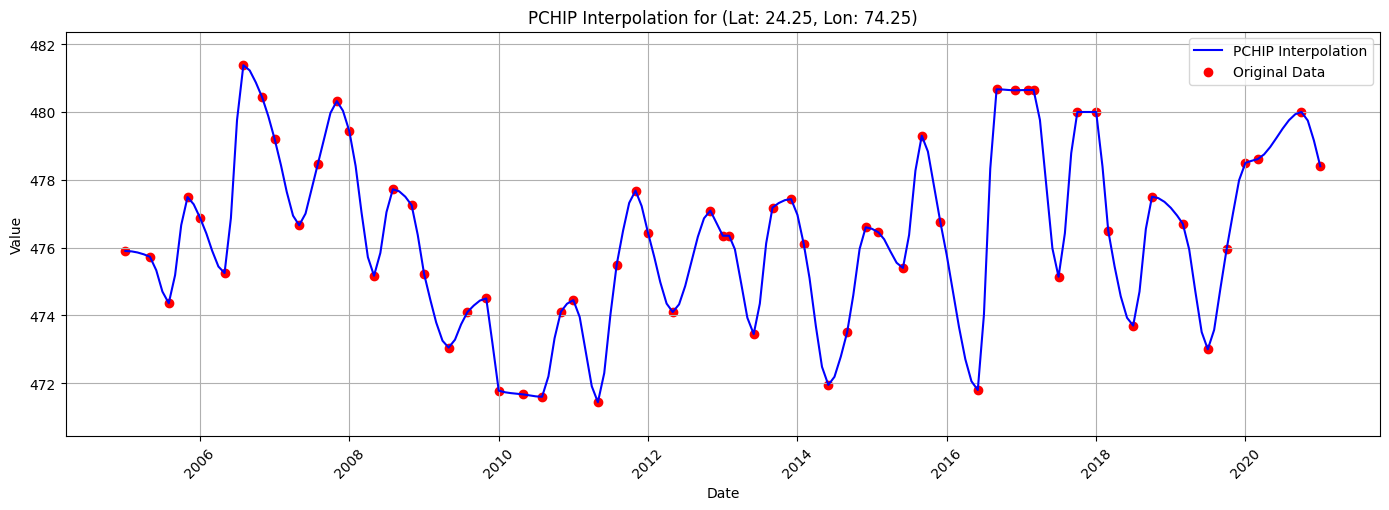

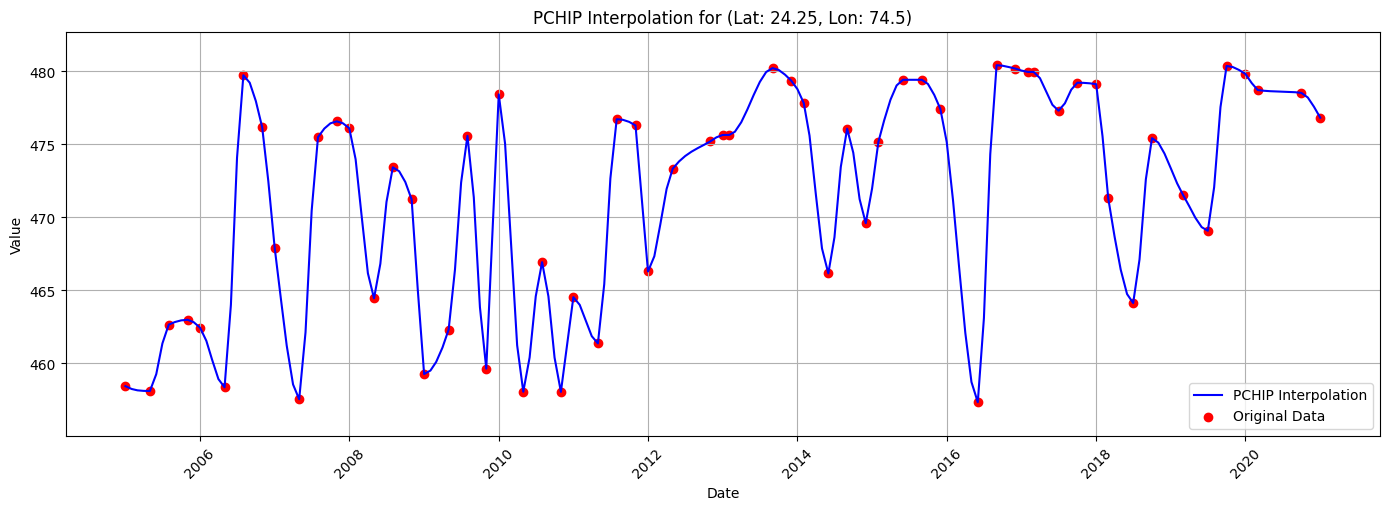

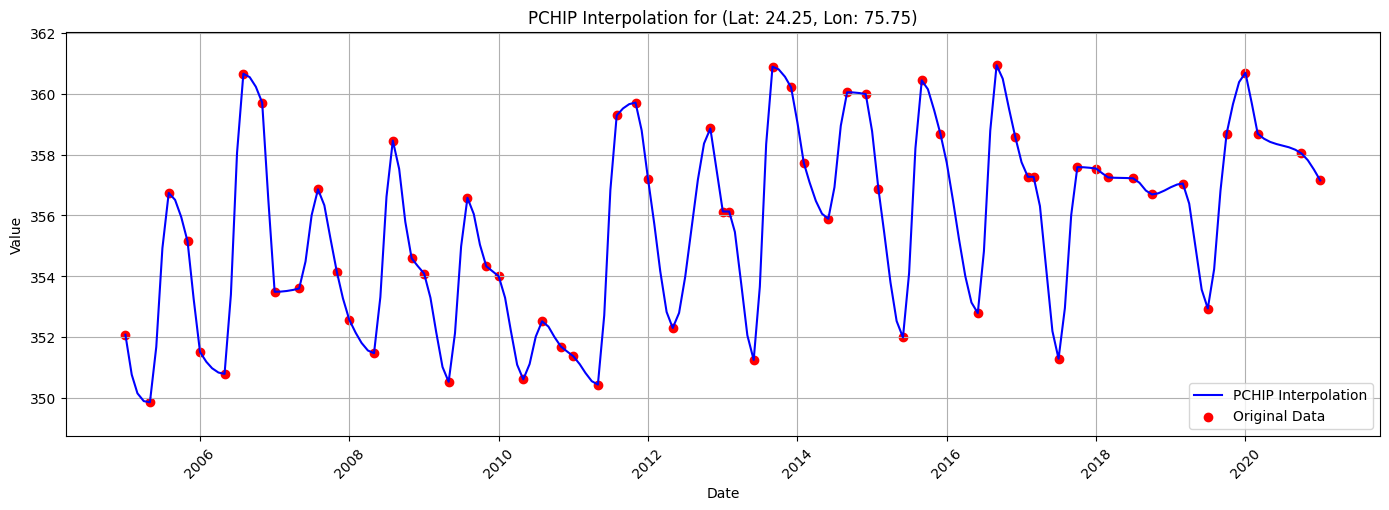

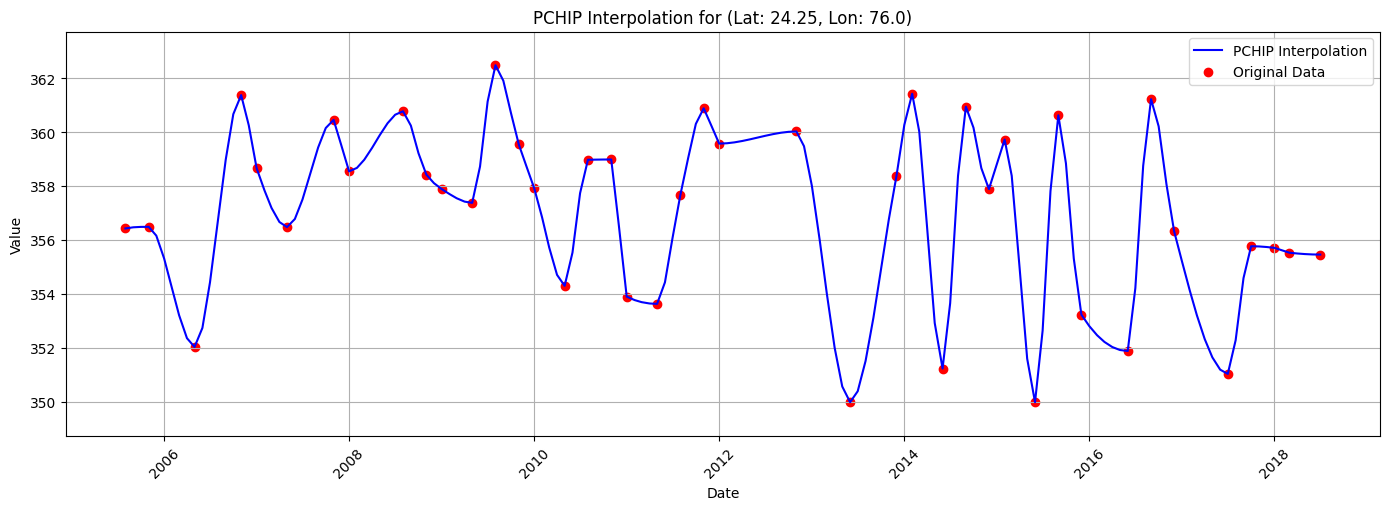

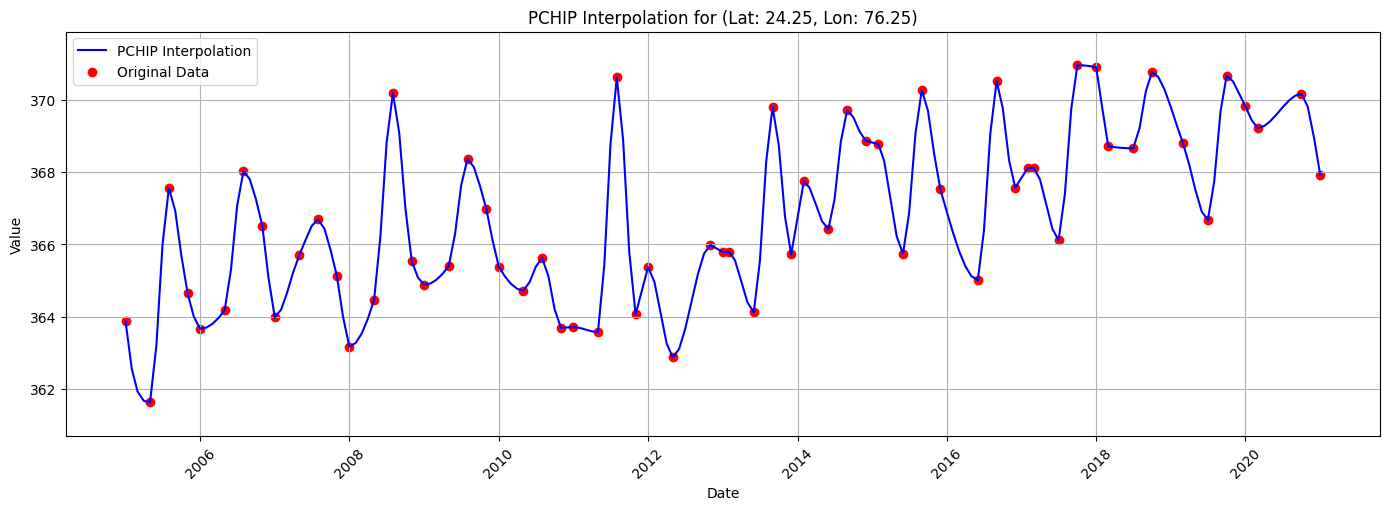

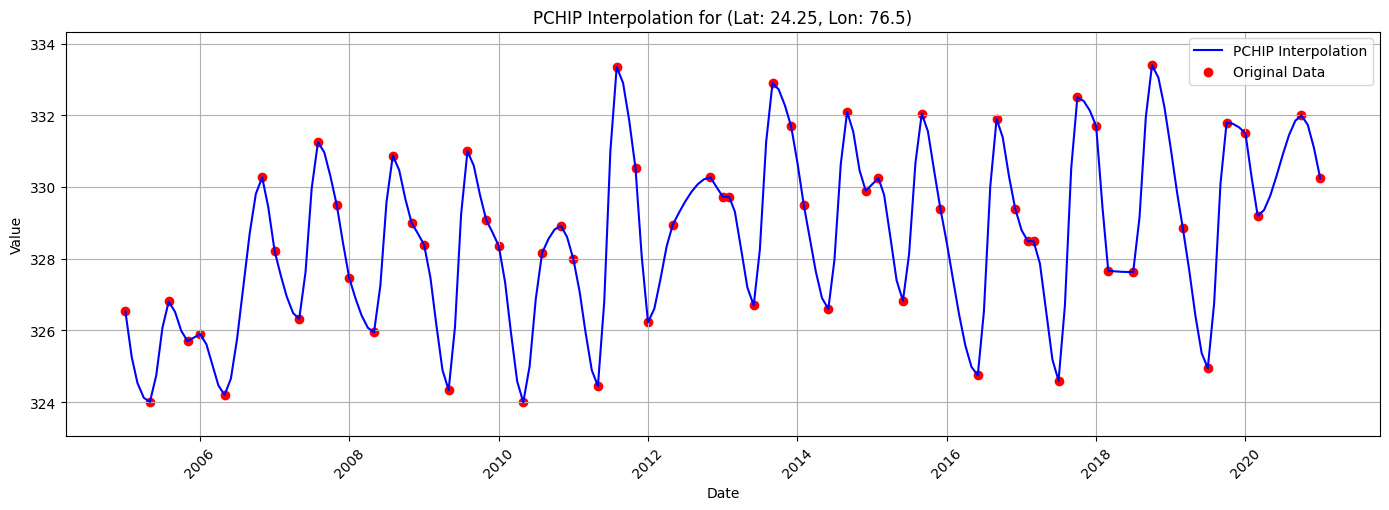

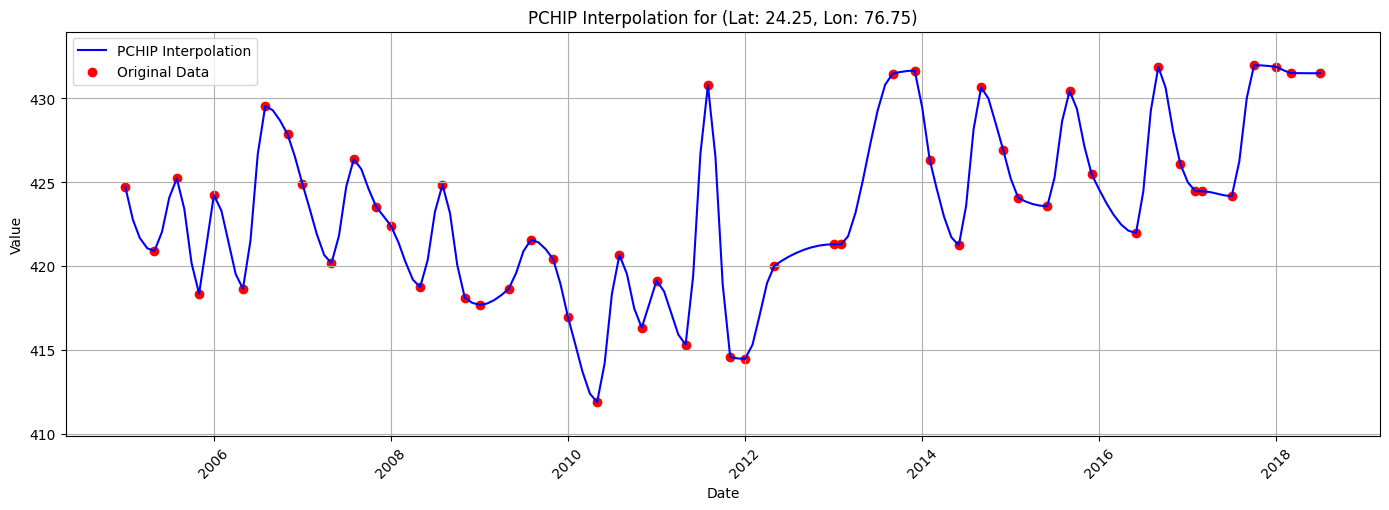

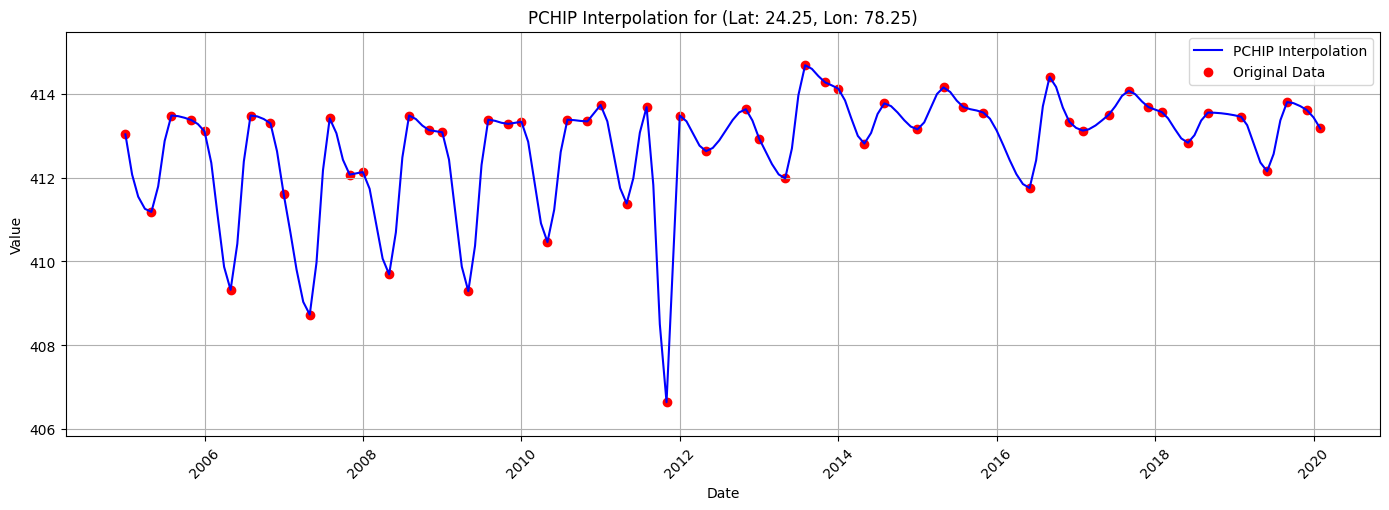

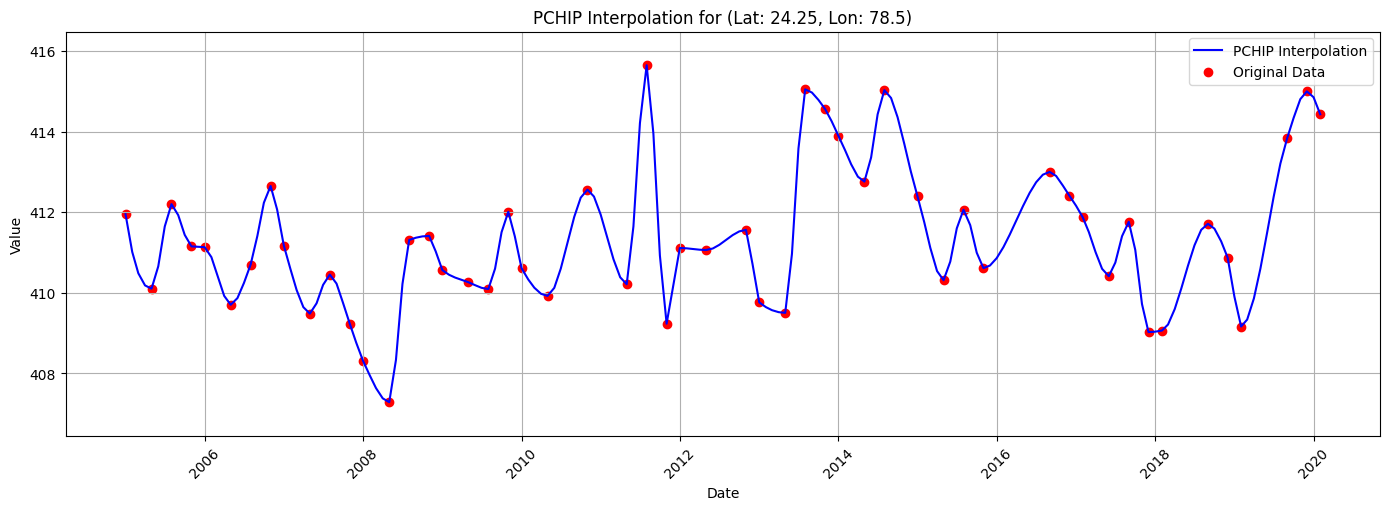

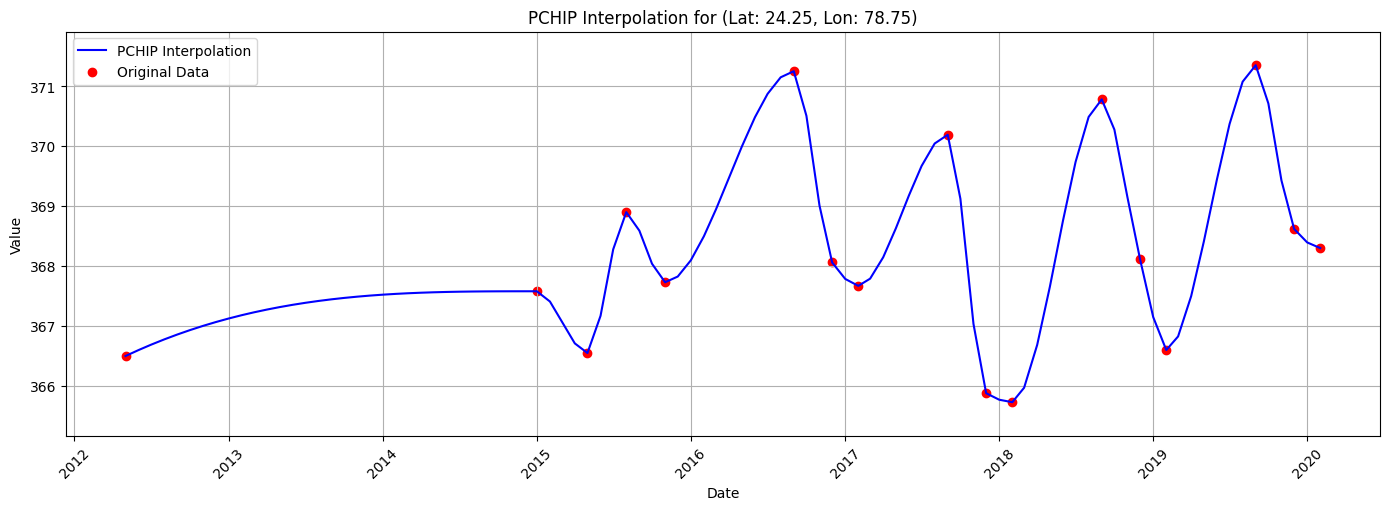

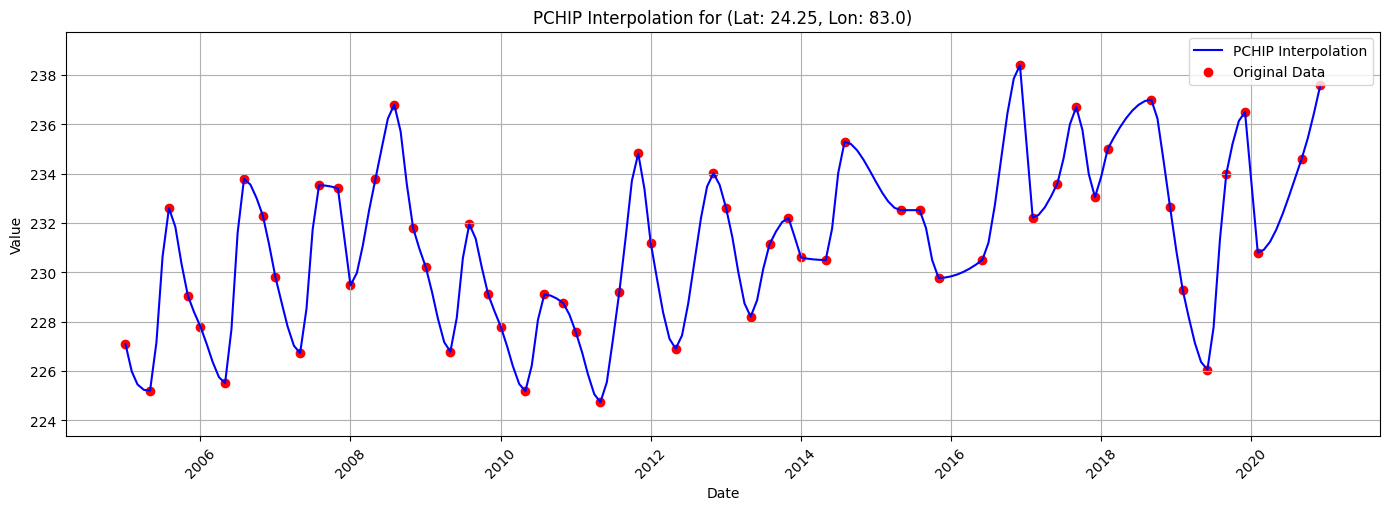

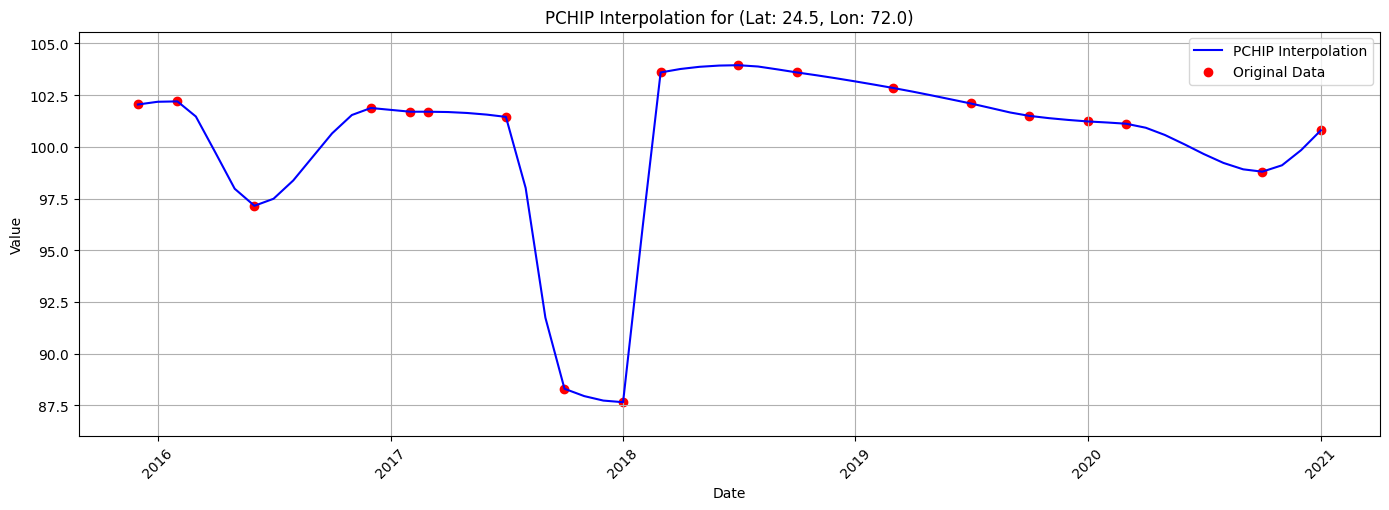

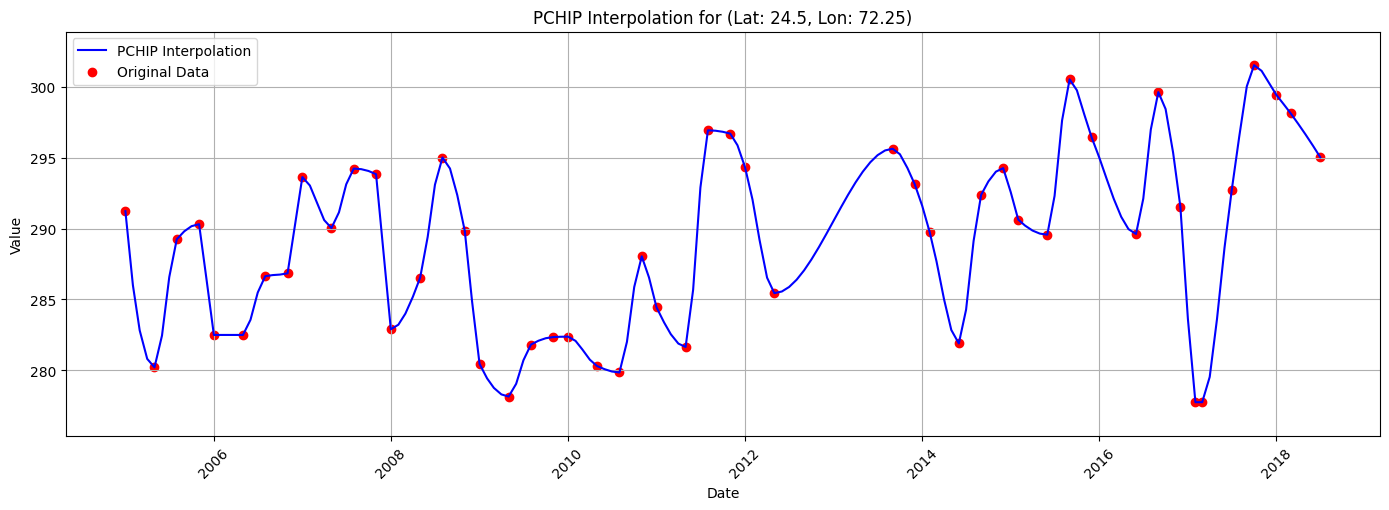

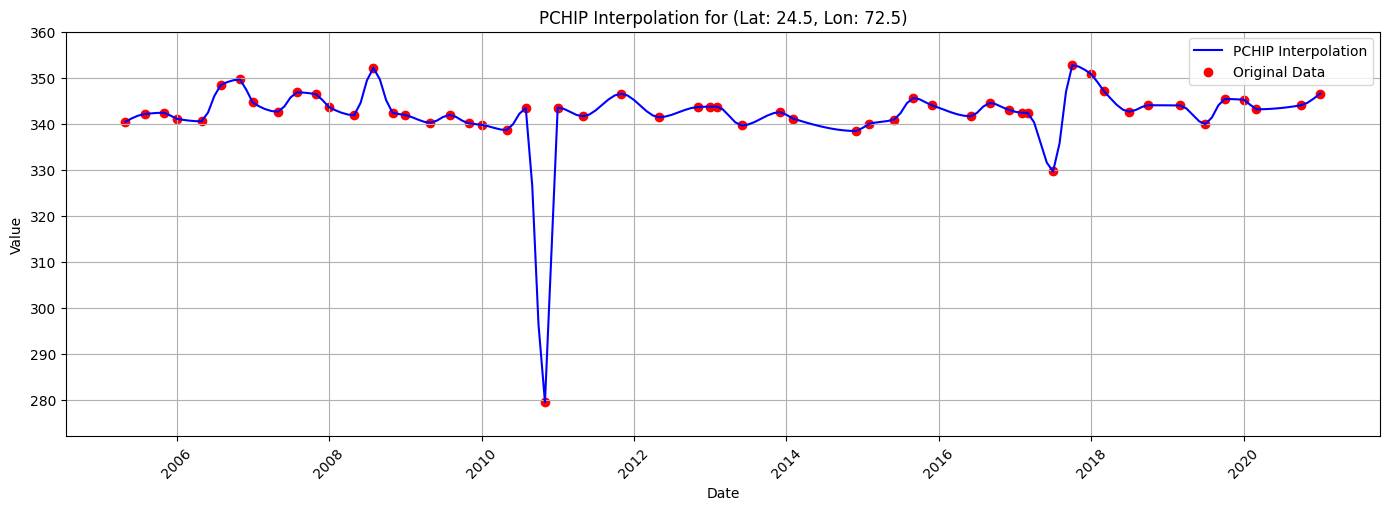

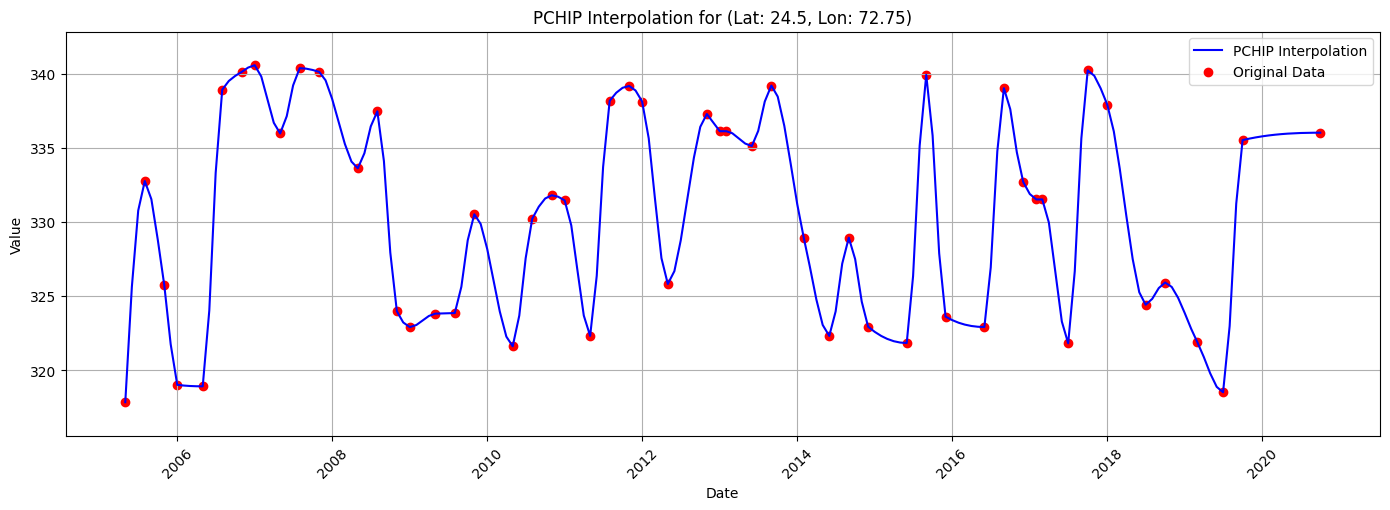

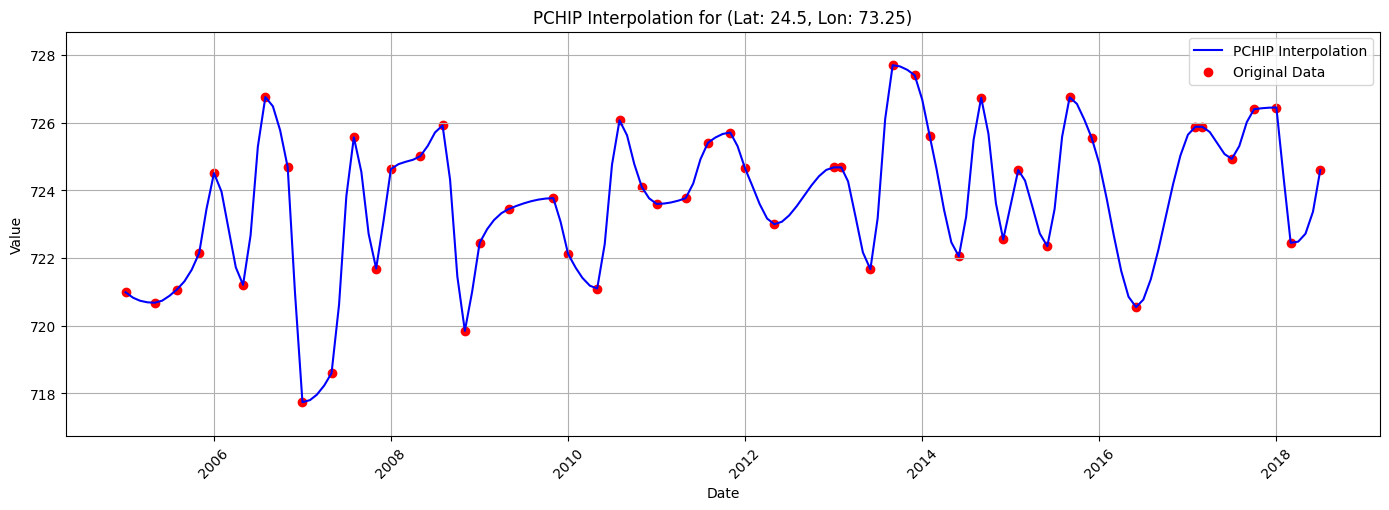

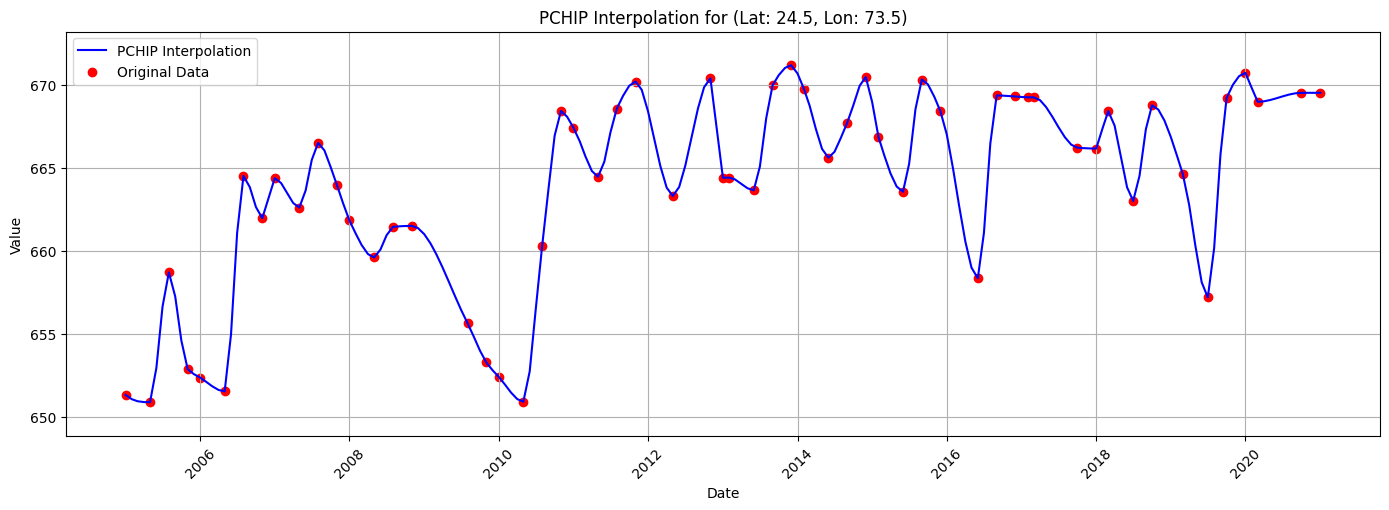

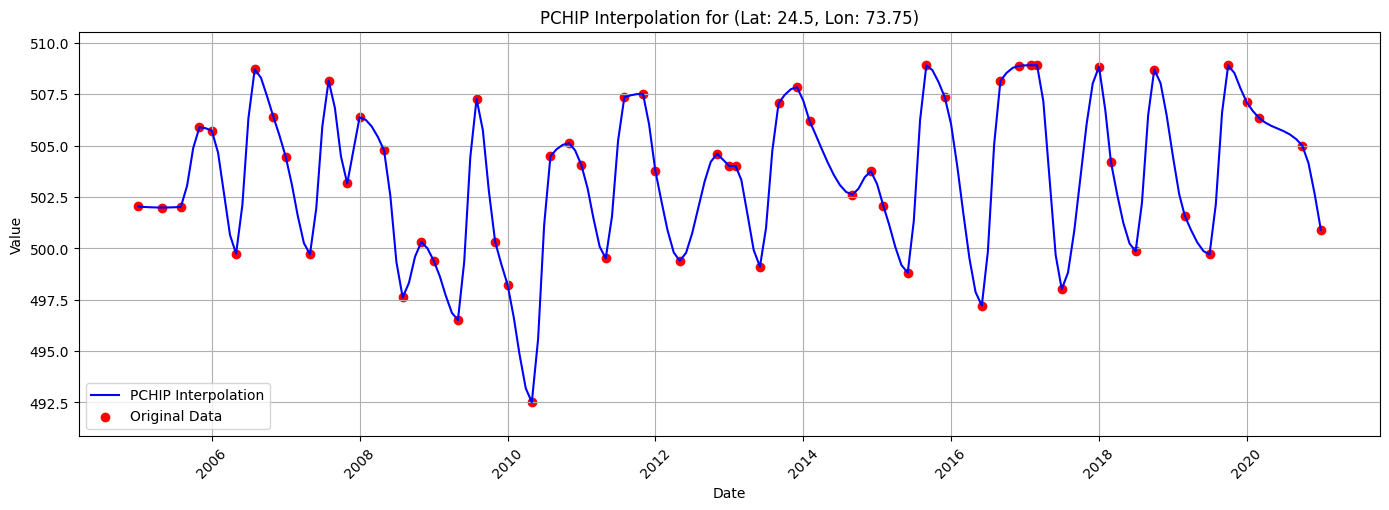

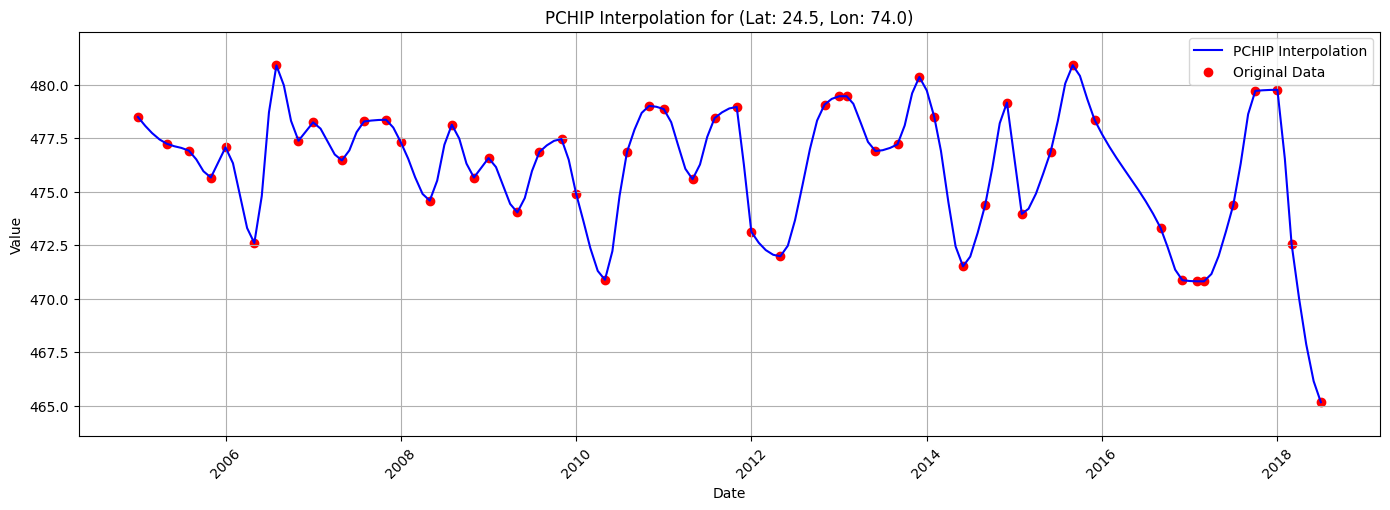

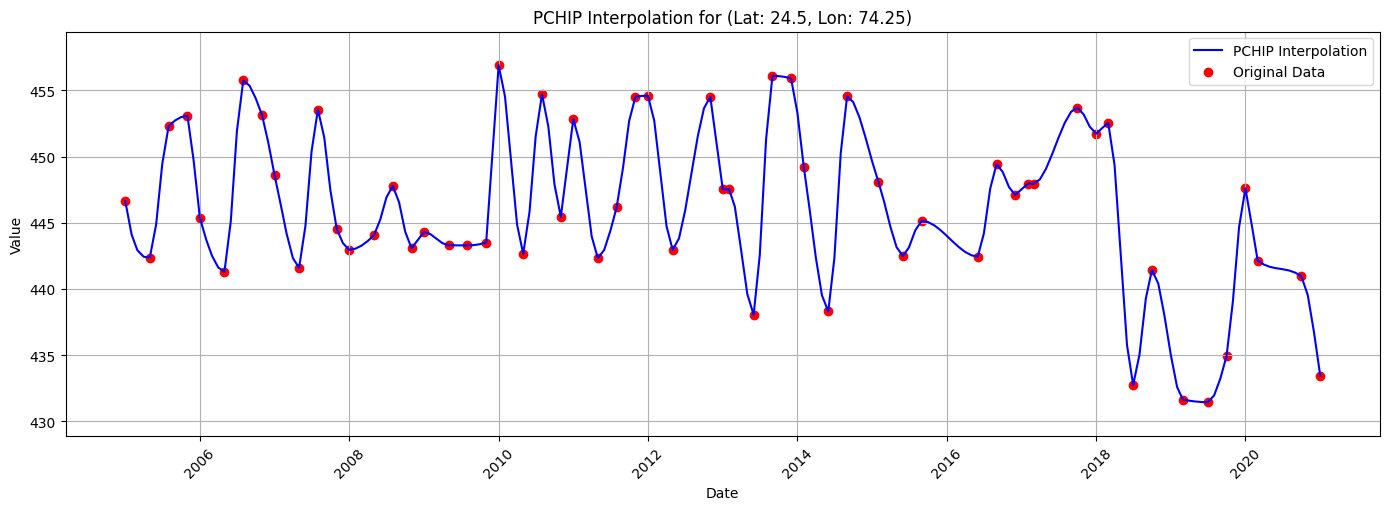

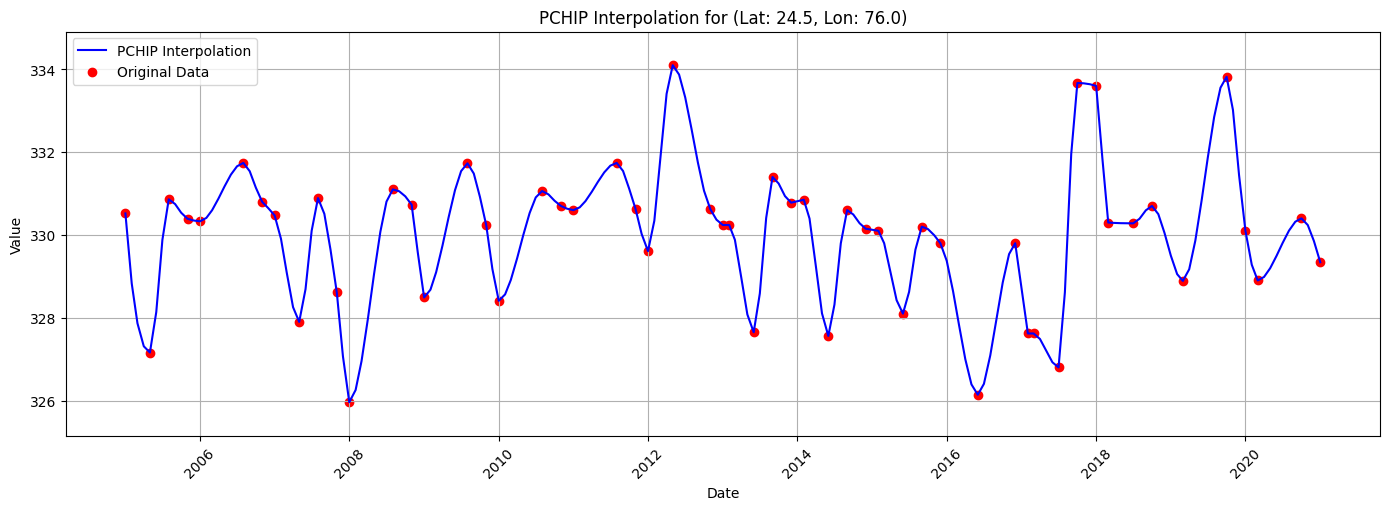

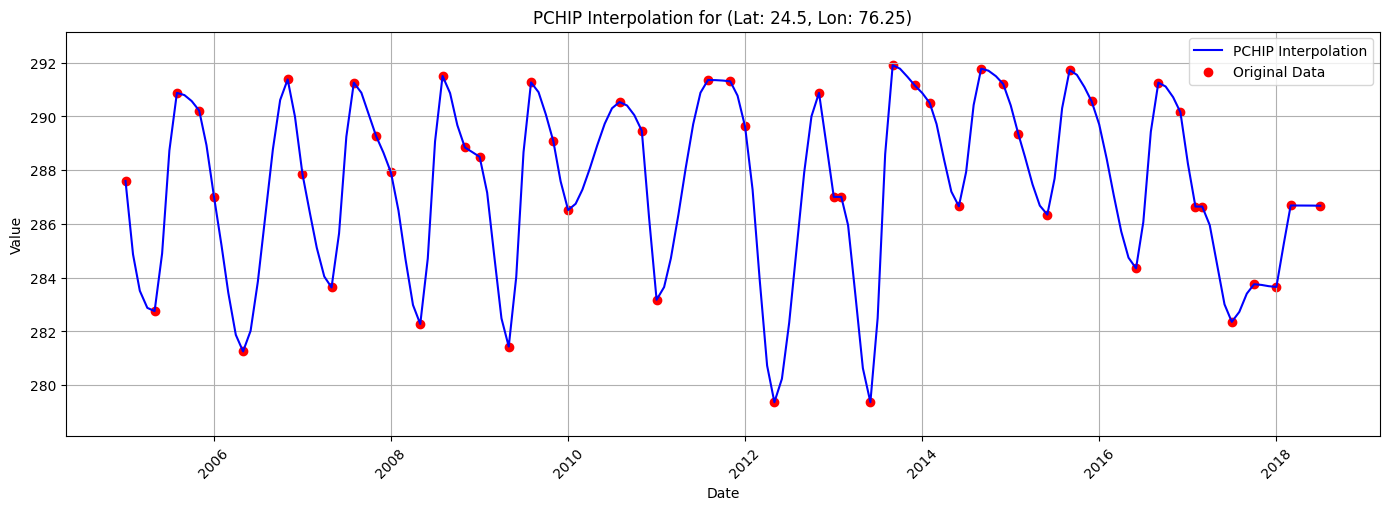

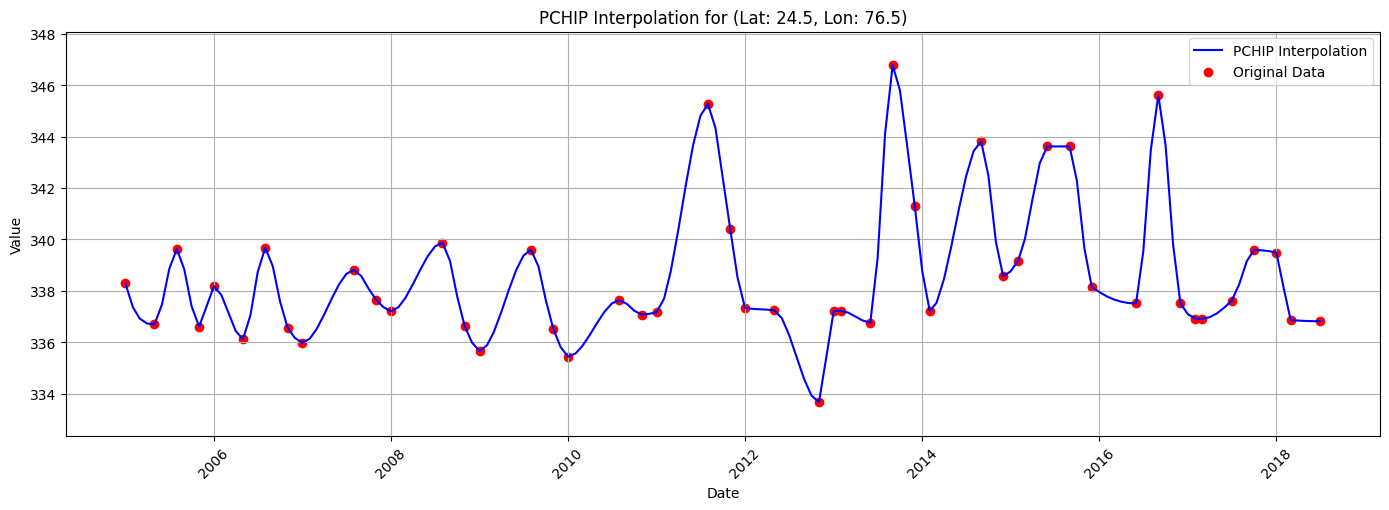

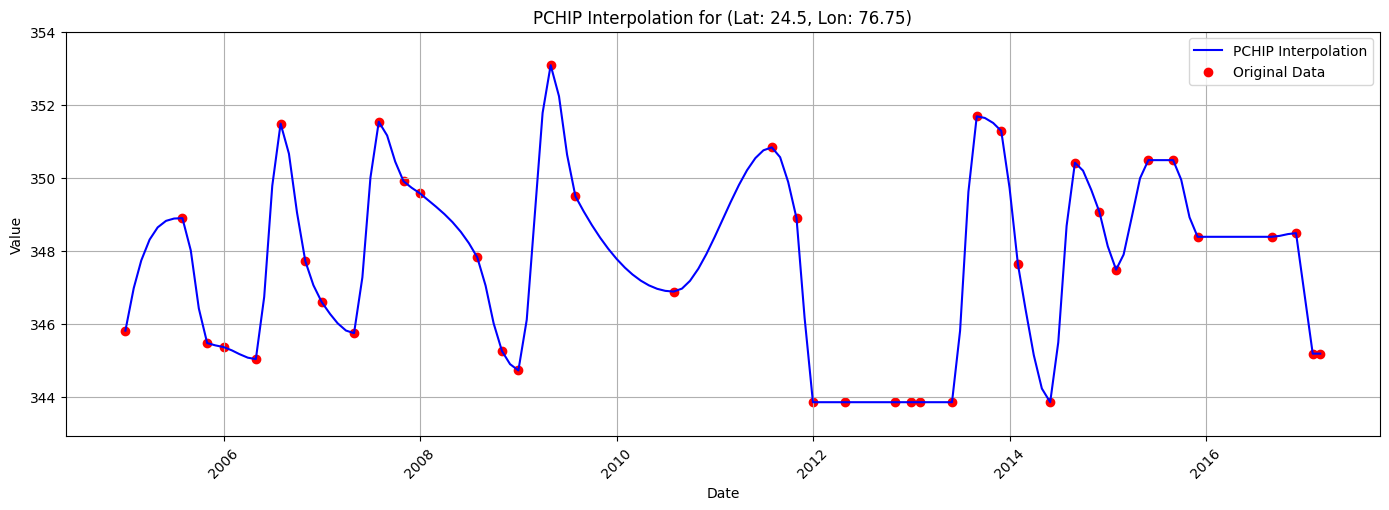

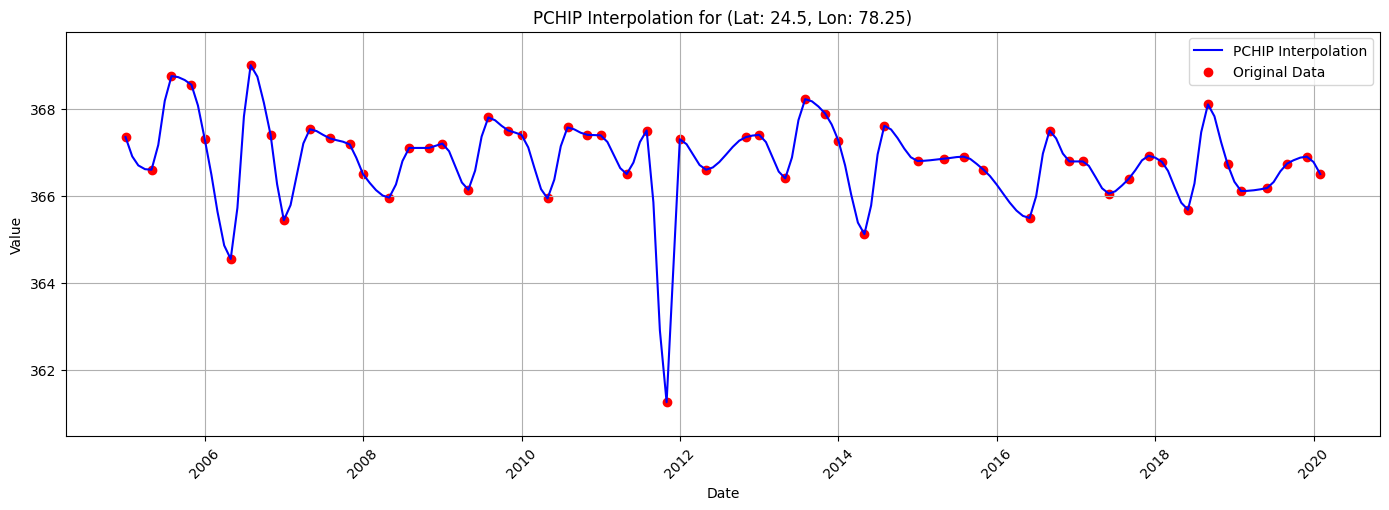

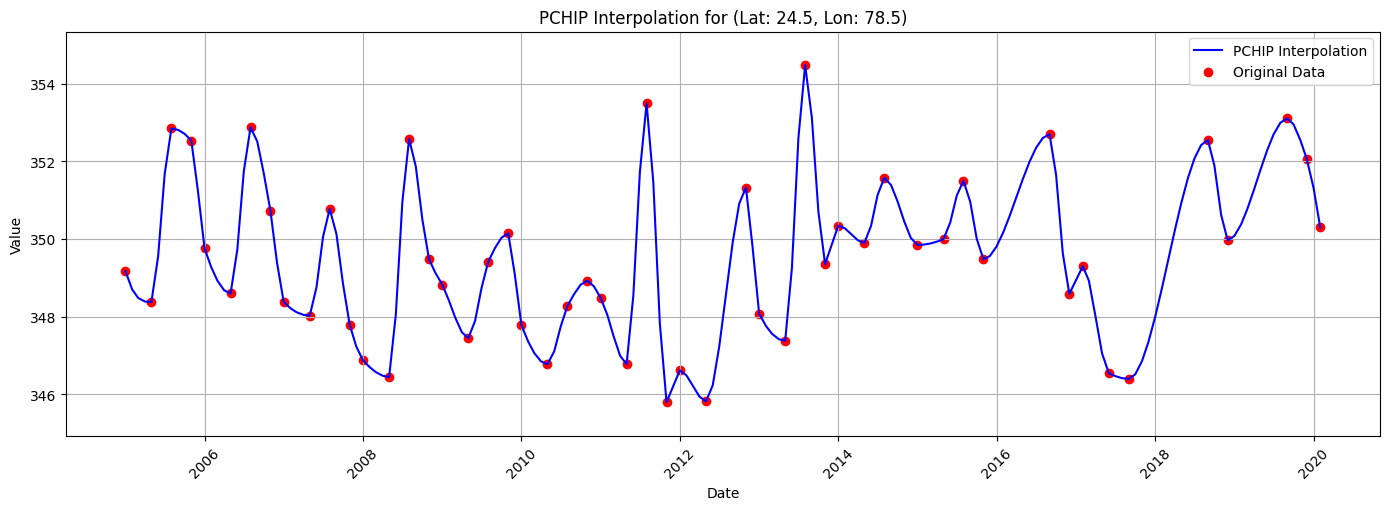

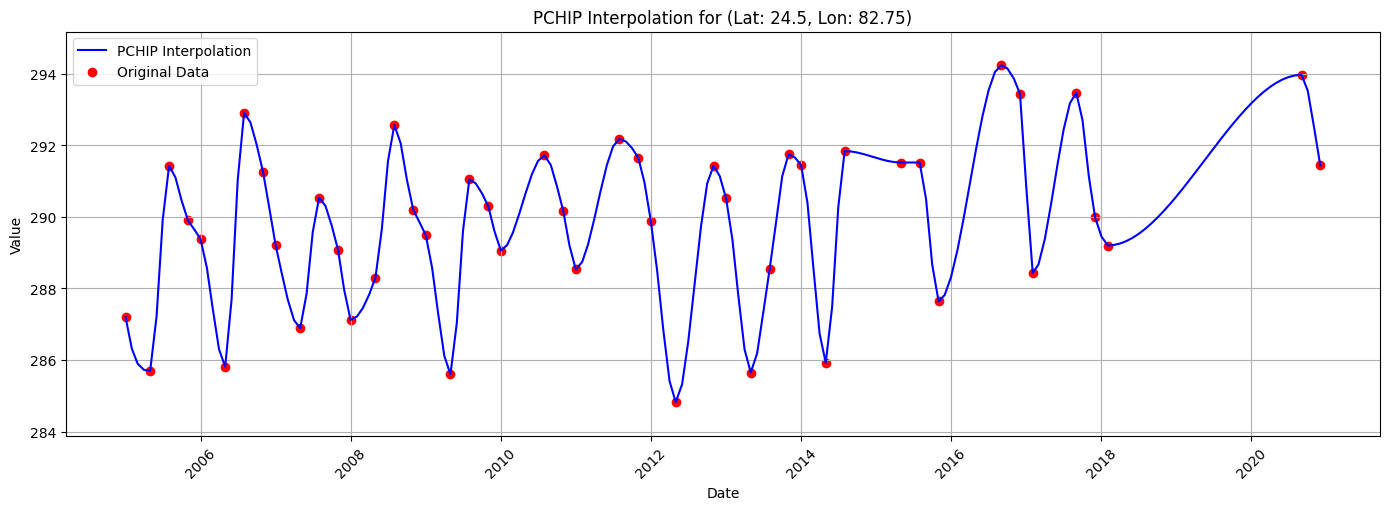

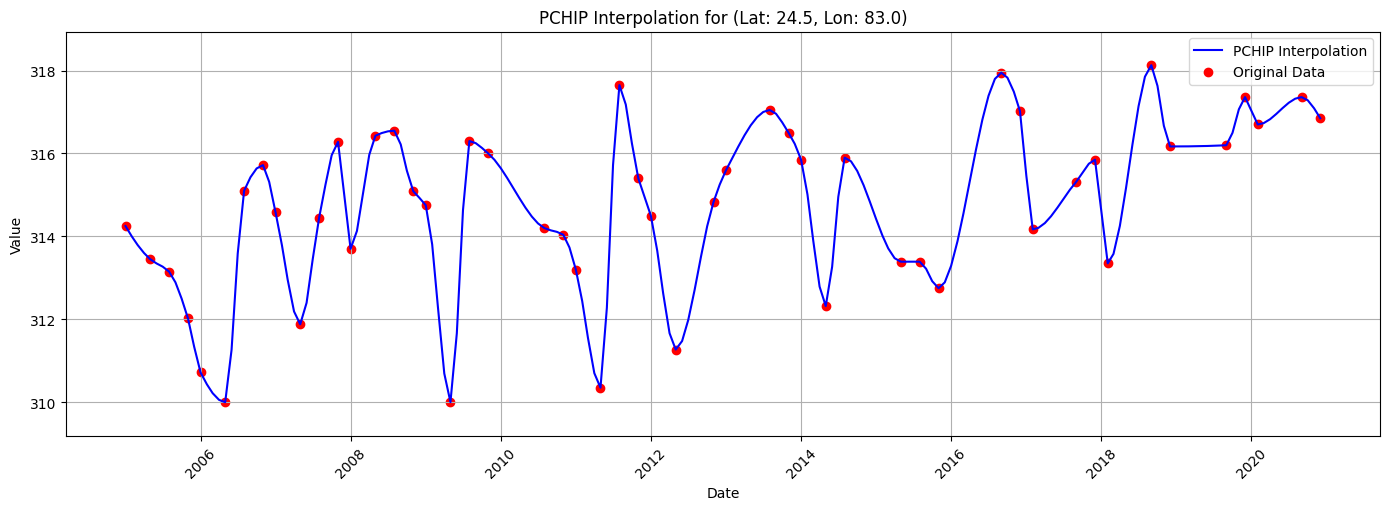

KeyboardInterrupt: 

In [2]:
import pandas as pd
import numpy as np
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt
from datetime import datetime

# ---------- Step 1: Load the dataset ----------
csv_file = 'Insitu_nan_row_removed.csv'
df = pd.read_csv(csv_file)
df.replace("Nan", np.nan, inplace=True)

# Convert all data columns (after Lat and Lon) to float
df.iloc[:, 2:] = df.iloc[:, 2:].astype(float)

# Extract date columns and convert them to datetime
date_cols = df.columns[2:]
date_times = pd.to_datetime(date_cols, format='%Y-%m')

# ---------- Step 2: Process and Plot Each Row ----------
for idx, row in df.iterrows():
    lat = row['Lat']
    lon = row['Lon']
    values = row[2:].values.astype(float)

    # Get valid indices (not NaN)
    valid_mask = ~np.isnan(values)
    if np.sum(valid_mask) < 4:
        print(f"Skipping row {idx} at (Lat, Lon) = ({lat}, {lon}) due to insufficient data.")
        continue

    valid_dates = date_times[valid_mask]
    valid_values = values[valid_mask]

    # Convert datetime to days for interpolation
    x = (valid_dates - valid_dates[0]).days
    x_all = (date_times - valid_dates[0]).days

    # Apply PCHIP interpolation
    interp = PchipInterpolator(x, valid_values)
    y_interp = interp(x_all)

    # Only consider plotting between the first and last valid points
    first_valid_idx = valid_mask.argmax()
    last_valid_idx = len(valid_mask) - np.argmax(valid_mask[::-1])

    plot_dates = date_times[first_valid_idx:last_valid_idx]
    plot_values = y_interp[first_valid_idx:last_valid_idx]

    # Set y-axis limits dynamically per plot
    local_min = np.min(plot_values)
    local_max = np.max(plot_values)
    padding = (local_max - local_min) * 0.1
    ymin = local_min - padding
    ymax = local_max + padding

    # ---------- Step 3: Plot ----------
    plt.figure(figsize=(14, 5))
    plt.plot(plot_dates, plot_values, label='PCHIP Interpolation', color='blue')
    plt.scatter(valid_dates, valid_values, label='Original Data', color='red')
    plt.title(f'PCHIP Interpolation for (Lat: {lat}, Lon: {lon})')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.ylim(ymin, ymax)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)

    plt.show()
